In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone,UNetBlockStyleMLP_backbone_NoFirstNorm
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.img_patch_stats_analysis_lib import *
from core.gaussian_mixture_lib import GaussianMixture_torch
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

In [5]:
def delta_GMM_score(Xt, train_Xmat, sigma, return_weights=False):
    # get squared distance matrix
    sqdist = torch.cdist(Xt.flatten(1), train_Xmat.flatten(1), p=2) ** 2
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    score = (torch.matmul(weights, train_Xmat) - Xt) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score


def delta_GMM_denoiser(Xt, train_Xmat, sigma):
    # get squared distance matrix
    sqdist = torch.cdist(Xt.flatten(1), train_Xmat.flatten(1), p=2) ** 2
    if isinstance(sigma, torch.Tensor):
        # Ensure sigma has the right shape for broadcasting
        if sigma.dim() == 0:
            # sigma is already a scalar, no change needed
            pass
        elif sigma.dim() == 1:
            sigma = sigma.unsqueeze(1)  # Shape becomes (k, 1)
        else:
            # For higher dimensional tensors, flatten to 1D then unsqueeze
            sigma = sigma.squeeze().unsqueeze(1)
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    # denoised = torch.matmul(weights, train_Xmat) # this is the original implementation
    # this is the more general implementation for tensors. 
    denoised = torch.matmul(weights, train_Xmat.flatten(1)).reshape(Xt.shape)
    return denoised

In [6]:
class EDMDeltaGMMScoreLoss:
    def __init__(self, train_Xmat, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
        self.train_Xmat = train_Xmat
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, X, labels=None, ):
        rnd_normal = torch.randn([X.shape[0],] + [1, ] * (X.ndim - 1), device=X.device)
        # unsqueeze to match the ndim of X
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        # maybe augment
        n = torch.randn_like(X) * sigma
        D_yn = net(X + n, sigma, cond=labels, )
        # D_gmm = delta_GMM_denoiser(X, self.train_Xmat, sigma)
        # fixed July27
        D_gmm = delta_GMM_denoiser(X + n, self.train_Xmat, sigma)
        # loss = weight * ((D_yn - X) ** 2)
        loss = weight * ((D_yn - D_gmm) ** 2)
        return loss

In [7]:
def visualize_trajs(x_traj, t_steps, pnts, title): # x0hat_traj, samples, 
    scaling = 1 / (t_steps ** 2 + 1).sqrt()
    scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
    plt.figure(figsize=(8, 8))
    plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
            scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
    plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
    plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
    plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.9, label="Training samples")
    plt.axis("equal")
    plt.title(title)
    plt.legend()
    return plt.gcf()

In [8]:
import pandas as pd

# Compare generated data statistics with training data
def compute_data_statistics_comparison(generated_samples, train_data, title=""):
    """
    Compare mean and covariance of generated samples with training data.
    """
    # Compute statistics for generated data
    gen_mean = generated_samples.mean(dim=0)
    gen_cov = torch.cov(generated_samples.T, correction=1)
    
    # Compute statistics for training data
    train_mean = train_data.mean(dim=0)
    train_cov = torch.cov(train_data.T, correction=1)
    
    # Compute differences
    mean_diff = torch.norm(gen_mean - train_mean).item()
    cov_diff = torch.norm(gen_cov - train_cov, 'fro').item()
    
    # Compute relative errors
    mean_rel_error = mean_diff / torch.norm(train_mean).item()
    cov_rel_error = cov_diff / torch.norm(train_cov, 'fro').item()
    
    print(f"{title}")
    print(f"Mean L2 difference: {mean_diff:.6f}")
    print(f"Mean relative error: {mean_rel_error:.6f}")
    print(f"Covariance Frobenius difference: {cov_diff:.6f}")
    print(f"Covariance relative error: {cov_rel_error:.6f}")
    print("-" * 50)
    
    return {
        'mean_diff': mean_diff,
        'cov_diff': cov_diff, 
        'mean_rel_error': mean_rel_error,
        'cov_rel_error': cov_rel_error
    }


In [9]:
def create_training_progress_animation(sample_store, pnts, objective_name, train_steps=None, sparse_slice=slice(None, None, 5)):
    """Create frames for training progress animation.
    
    Args:
        sample_store: Dictionary with training step keys and sample data values
        pnts: Points for visualization
        objective_name: Name of the objective (e.g., "ESM", "DSM")
        train_steps: List of training steps to animate (if None, uses all keys)
    
    Returns:
        List of PIL Image frames
    """
    import matplotlib.animation as animation
    from matplotlib.animation import PillowWriter
    import io
    from PIL import Image
    
    if train_steps is None:
        train_steps = list(sample_store.keys())
    
    frames = []
    
    for train_step in train_steps:
        samples, x_traj, x0hat_traj, t_steps = sample_store[train_step]
        # Create frame
        title = f"{objective_name} to Delta GMM | step {train_step}"
        fig = visualize_trajs(x_traj[:, sparse_slice], t_steps, pnts, title)
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close(fig)
    
    return frames

def save_training_gifs(frames_esm, filename, savedirs=[]):
    """Save training progress animations as GIFs."""
    # Save ESM GIF
    for folder in savedirs:
        frames_esm[0].save(join(folder, filename+".gif"), 
                           save_all=True, append_images=frames_esm[1:], 
                           duration=800, loop=0)

In [10]:
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone_NoFirstNorm

In [74]:
savedir = join(saveroot, "DSM_vs_Delta_ESM_loss_highdim_GMM_128dim_512batch_data_cmp")
os.makedirs(savedir, exist_ok=True)

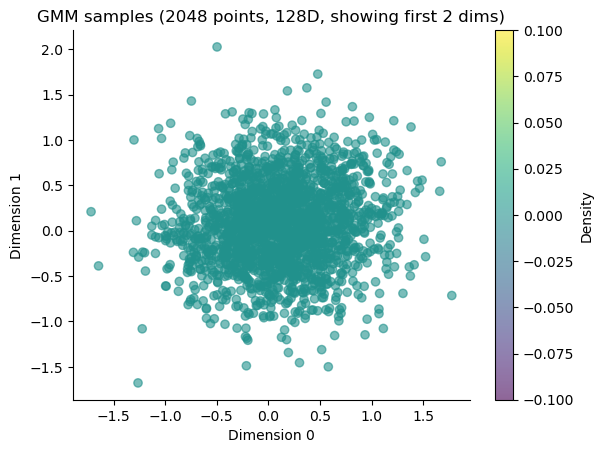

In [27]:
# Generate randomized gaussian mixture at ndim dimensions
ndim = 128  # Set desired dimensionality
npnts = 2048  # Set desired number of points
n_components = 3  # Number of Gaussian components

torch.manual_seed(42)
# Generate random means
mus = [torch.randn(ndim) * 2.0 for _ in range(n_components)]
# Generate random covariance matrices (positive definite)
covs = []
for _ in range(n_components):
    # Generate random matrix and make it positive definite
    A = torch.randn(ndim, ndim)
    cov = A @ A.T + torch.eye(ndim) * 0.1  # Add small diagonal term for numerical stability
    covs.append(cov)
# Generate random weights
weights = torch.rand(n_components) + 0.5  # weights between 0.5 and 1.5
weights = weights.tolist()
gmm = GaussianMixture_torch(mus, covs, weights)
pnts, _, _ = gmm.sample(npnts)
pnts = pnts / pnts.std() * 0.5
# For high-dimensional data, we can only plot first 2 dimensions
if ndim >= 2:
    density = gmm.pdf(pnts)
    plt.scatter(pnts[:, 0], pnts[:, 1], c=density, cmap="viridis", alpha=0.6)
    plt.xlabel(f"Dimension 0")
    plt.ylabel(f"Dimension 1")
    plt.title(f"GMM samples ({npnts} points, {ndim}D, showing first 2 dims)")
    plt.colorbar(label="Density")
    plt.show()
else:
    print(f"Generated {npnts} samples in {ndim}D space")

### Training runs

In [75]:
pnts = torch.load(join(savedir, "training_data.pth"))["pnts"]

/tmp/ipykernel_121594/3532845306.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pnts = torch.load(join(savedir, "training_data.pth"))["pnts"]


In [28]:
device = get_device()
sigma_data = pnts.std().item()
torch.save({"pnts": pnts, "mus": mus, "covs": covs, "weights": weights}, join(savedir, "training_data.pth"))

nlayers = 6
nhidden = 192
time_embed_dim = 64
batch_size = 128
nepochs = 50000
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu()#,# x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

record_step_list = [*range(0, 50000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
device = get_device()
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"Point cloud dataset {pnts.shape[0]} samples, {ndim} features | batch size: {batch_size}, epochs: {nepochs} | nlayers: {nlayers}, nhidden: {nhidden}, time_embed_dim: {time_embed_dim}")
model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
model_precd_esm = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_esm, loss_traj_esm = train_score_model_custom_loss(pnts, model_precd_esm, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=nepochs, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)
torch.save(loss_traj_esm, join(savedir, f"loss_traj_esm_B{batch_size}.pth"))
torch.save(sample_store, join(savedir, f"sample_store_esm_B{batch_size}.pth"))
torch.save(model_precd_esm, join(savedir, f"model_precd_esm_B{batch_size}.pth"))

sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu()#, x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=nepochs, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm, join(savedir, f"loss_traj_dsm_B{batch_size}.pth"))
torch.save(sample_store, join(savedir, f"sample_store_dsm_B{batch_size}.pth"))
torch.save(model_precd_dsm, join(savedir, f"model_precd_dsm_B{batch_size}.pth"))


# sample_store = {}
# loss_store = {}
# def sampling_callback_fn(epoch, loss, model, manual_seed=0):
#     loss_store[epoch] = loss
#     noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
#     x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
#                     num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
#     sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

# model_esm2 = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
# model_precd_esm2 = EDMPrecondWrapper(model_esm2, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
# model_precd_esm2, loss_traj_esm2 = train_score_model_custom_loss(pnts, model_precd_esm2, edm_delta_gmm_loss_fn, 
#                                     lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
#                                     callback=sampling_callback_fn, callback_freq=0, 
#                                     callback_step_list=record_step_list)
# torch.save(loss_traj_esm2, join(savedir, "loss_traj_esm_2.pth"))
# torch.save(sample_store, join(savedir, "sample_store_esm_2.pth"))
# torch.save(model_precd_esm2, join(savedir, "model_precd_esm_2.pth"))




# sample_store = {}
# loss_store = {}
# def sampling_callback_fn(epoch, loss, model, manual_seed=0):
#     loss_store[epoch] = loss
#     noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
#     x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
#                     num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
#     sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
# model_dsm2 = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
# model_precd_dsm2 = EDMPrecondWrapper(model_dsm2, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
# model_precd_dsm2, loss_traj_dsm2 = train_score_model_custom_loss(pnts, model_precd_dsm2, edm_loss_fn, 
#                                     lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
#                                     callback=sampling_callback_fn, callback_freq=0, 
#                                     callback_step_list=record_step_list)

# torch.save(loss_traj_dsm2, join(savedir, "loss_traj_dsm_2.pth"))
# torch.save(sample_store, join(savedir, "sample_store_dsm_2.pth"))
# torch.save(model_precd_dsm2, join(savedir, "model_precd_dsm_2.pth"))


Point cloud dataset 2048 samples, 128 features | batch size: 128, epochs: 50000 | nlayers: 6, nhidden: 192, time_embed_dim: 64


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.306


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.406


In [29]:
device = get_device()
sigma_data = pnts.std().item()
torch.save({"pnts": pnts, "mus": mus, "covs": covs, "weights": weights}, join(savedir, "training_data.pth"))

nlayers = 6
nhidden = 192
time_embed_dim = 64
batch_size = 4096
nepochs = 50000
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu()#,# x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

record_step_list = [*range(0, 50000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
device = get_device()
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"Point cloud dataset {pnts.shape[0]} samples, {ndim} features | batch size: {batch_size}, epochs: {nepochs} | nlayers: {nlayers}, nhidden: {nhidden}, time_embed_dim: {time_embed_dim}")
model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
model_precd_esm = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_esm, loss_traj_esm = train_score_model_custom_loss(pnts, model_precd_esm, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=nepochs, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)
torch.save(loss_traj_esm, join(savedir, f"loss_traj_esm_B{batch_size}.pth"))
torch.save(sample_store, join(savedir, f"sample_store_esm_B{batch_size}.pth"))
torch.save(model_precd_esm, join(savedir, f"model_precd_esm_B{batch_size}.pth"))



sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu()#, x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=nepochs, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm, join(savedir, f"loss_traj_dsm_B{batch_size}.pth"))
torch.save(sample_store, join(savedir, f"sample_store_dsm_B{batch_size}.pth"))
torch.save(model_precd_dsm, join(savedir, f"model_precd_dsm_B{batch_size}.pth"))

Point cloud dataset 2048 samples, 128 features | batch size: 4096, epochs: 50000 | nlayers: 6, nhidden: 192, time_embed_dim: 64


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.314


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 1.389


In [77]:
device = get_device()
sigma_data = pnts.std().item()
# torch.save({"pnts": pnts, "mus": mus, "covs": covs, "weights": weights}, join(savedir, "training_data.pth"))

nlayers = 8
nhidden = 256
time_embed_dim = 128
batch_size = 12288
nepochs = 100000
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=False) # , x_traj, x0hat_traj, t_steps
    sample_store[epoch] = x_out.cpu()#,# x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

record_step_list = [*range(0, 100000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
device = get_device()
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"Point cloud dataset {pnts.shape[0]} samples, {ndim} features | batch size: {batch_size}, epochs: {nepochs} | nlayers: {nlayers}, nhidden: {nhidden}, time_embed_dim: {time_embed_dim}")
model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
model_precd_esm = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_esm, loss_traj_esm = train_score_model_custom_loss(pnts, model_precd_esm, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=nepochs, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)
torch.save(loss_traj_esm, join(savedir, f"loss_traj_esm_B{batch_size}.pth"))
torch.save(sample_store, join(savedir, f"sample_store_esm_B{batch_size}.pth"))
torch.save(model_precd_esm, join(savedir, f"model_precd_esm_B{batch_size}.pth"))


sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=False) # , x_traj, x0hat_traj, t_steps
    sample_store[epoch] = x_out.cpu()#, x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=nlayers, nhidden=nhidden, time_embed_dim=time_embed_dim,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=nepochs, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm, join(savedir, f"loss_traj_dsm_B{batch_size}.pth"))
torch.save(sample_store, join(savedir, f"sample_store_dsm_B{batch_size}.pth"))
torch.save(model_precd_dsm, join(savedir, f"model_precd_dsm_B{batch_size}.pth"))

Point cloud dataset 2048 samples, 128 features | batch size: 12288, epochs: 100000 | nlayers: 8, nhidden: 256, time_embed_dim: 128


  0%|          | 0/100000 [00:00<?, ?it/s]

step 0 loss 1.443


KeyboardInterrupt: 

### Analysis

In [11]:
savedir = join(saveroot, "DSM_vs_Delta_ESM_loss_highdim_GMM_128dim_512batch_data_cmp")

In [16]:
train_data = torch.load(join(savedir, "training_data.pth"))
pnts = train_data["pnts"]
mus = train_data["mus"]
covs = train_data["covs"]

/tmp/ipykernel_121594/3325932536.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(join(savedir, "training_data.pth"))


In [12]:
figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_dim_batchsize_cmp"
os.makedirs(figdir, exist_ok=True)

/tmp/ipykernel_687894/374910470.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_traj_esm_B128 = torch.load(join(savedir, f"loss_traj_esm.pth"))
/tmp/ipykernel_68789

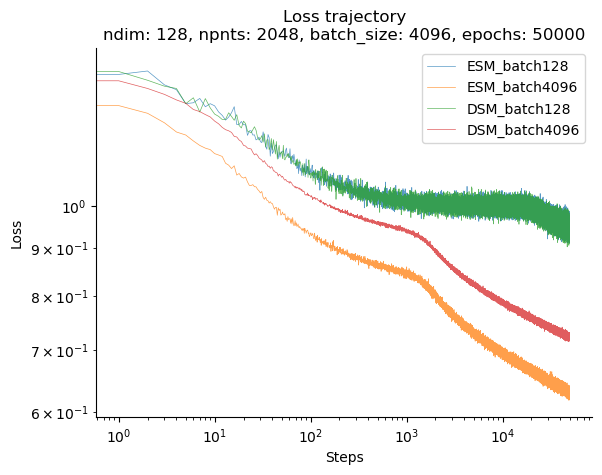

In [31]:
loss_traj_esm_B128 = torch.load(join(savedir, f"loss_traj_esm.pth"))
loss_traj_esm_B4096  = torch.load(join(savedir, f"loss_traj_esm_B4096.pth"))
loss_traj_dsm_B128 = torch.load(join(savedir, f"loss_traj_dsm.pth"))
loss_traj_dsm_B4096 = torch.load(join(savedir, f"loss_traj_dsm_B4096.pth"))
plt.plot(loss_traj_esm_B128, label="ESM_batch128", alpha=0.75, lw=0.5)
plt.plot(loss_traj_esm_B4096, label="ESM_batch4096", alpha=0.75, lw=0.5)
# plt.plot(loss_traj_esm2, label="ESM2", alpha=0.75, lw=0.5)
plt.plot(loss_traj_dsm_B128, label="DSM_batch128", alpha=0.75, lw=0.5)
plt.plot(loss_traj_dsm_B4096, label="DSM_batch4096", alpha=0.75, lw=0.5)
# plt.plot(loss_traj_dsm2, label="DSM2", alpha=0.75, lw=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title(f"Loss trajectory\nndim: {ndim}, npnts: {npnts}, batch_size: {batch_size}, epochs: {nepochs}")
plt.legend()
saveallforms(figdir, "DSM_vs_ESM_loss_traj_cmp_batchsize_cmp_normed")
plt.show()

/tmp/ipykernel_687894/3903318473.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_traj_esm_B128 = torch.load(join(savedir, f"loss_traj_esm.pth"))
/tmp/ipykernel_6878

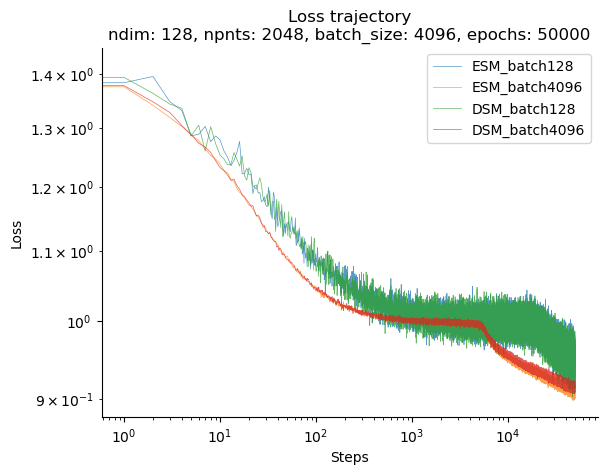

In [21]:
loss_traj_esm_B128 = torch.load(join(savedir, f"loss_traj_esm.pth"))
loss_traj_esm_B4096  = torch.load(join(savedir, f"loss_traj_esm_B4096.pth"))
loss_traj_dsm_B128 = torch.load(join(savedir, f"loss_traj_dsm.pth"))
loss_traj_dsm_B4096 = torch.load(join(savedir, f"loss_traj_dsm_B4096.pth"))
plt.plot(loss_traj_esm_B128, label="ESM_batch128", alpha=0.75, lw=0.5)
plt.plot(loss_traj_esm_B4096, label="ESM_batch4096", alpha=0.75, lw=0.5)
# plt.plot(loss_traj_esm2, label="ESM2", alpha=0.75, lw=0.5)
plt.plot(loss_traj_dsm_B128, label="DSM_batch128", alpha=0.75, lw=0.5)
plt.plot(loss_traj_dsm_B4096, label="DSM_batch4096", alpha=0.75, lw=0.5)
# plt.plot(loss_traj_dsm2, label="DSM2", alpha=0.75, lw=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title(f"Loss trajectory\nndim: {ndim}, npnts: {npnts}, batch_size: {batch_size}, epochs: {nepochs}")
plt.legend()
saveallforms(figdir, "DSM_vs_ESM_loss_traj_cmp_batchsize128")
plt.show()

In [25]:
pnts.std()

tensor(11.5542, device='cuda:0')

In [33]:
import torch
device = get_device()
pnts = pnts.to(device)
sigma = 1.0
model_precd_esm = torch.load(join(savedir, f"model_precd_esm_B4096.pth"))
model_precd_dsm  = torch.load(join(savedir, f"model_precd_dsm_B4096.pth"))
for sigma in [0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]:
    # Create multiple noised versions for better evaluation
    num_reps = 10
    # Create all noised points and sigma vectors at once
    pnts_rep = pnts.repeat(num_reps, 1)
    noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
    sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
    noised_pnts = noised_pnts.to(device)
    sigma_vec = sigma_vec.to(device)
    denoised_esm = model_precd_esm(noised_pnts, sigma_vec)
    denoised_dsm = model_precd_dsm(noised_pnts, sigma_vec)
    denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])
    mmse_esm = torch.mean((denoised_esm - denoised_gmm) ** 2)
    mmse_dsm = torch.mean((denoised_dsm - denoised_gmm) ** 2)
    mmse_gmm = torch.mean((denoised_gmm - pnts_rep) ** 2)
    print(f"sigma: {sigma}\tMMSE of ESM - GMM: {mmse_esm.item():.5f}\tMMSE of DSM - GMM: {mmse_dsm.item():.5f}\tMMSE of GMM - X0: {mmse_gmm.item():.5f}")
    # print(f"MMSE of DSM: {mmse_dsm.item()}")

/tmp/ipykernel_687894/3079812079.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_precd_esm = torch.load(join(savedir, f"model_precd_esm_B4096.pth"))
/tmp/ipykernel

sigma: 0.002	MMSE of ESM - GMM: 0.00000	MMSE of DSM - GMM: 0.00000	MMSE of GMM - X0: 0.00000
sigma: 0.005	MMSE of ESM - GMM: 0.00003	MMSE of DSM - GMM: 0.00003	MMSE of GMM - X0: 0.00000
sigma: 0.01	MMSE of ESM - GMM: 0.00010	MMSE of DSM - GMM: 0.00010	MMSE of GMM - X0: 0.00000
sigma: 0.05	MMSE of ESM - GMM: 0.00180	MMSE of DSM - GMM: 0.00178	MMSE of GMM - X0: 0.00000
sigma: 0.1	MMSE of ESM - GMM: 0.00619	MMSE of DSM - GMM: 0.00614	MMSE of GMM - X0: 0.00000
sigma: 0.5	MMSE of ESM - GMM: 0.08669	MMSE of DSM - GMM: 0.08635	MMSE of GMM - X0: 0.00000
sigma: 1.0	MMSE of ESM - GMM: 0.16204	MMSE of DSM - GMM: 0.16191	MMSE of GMM - X0: 0.01201
sigma: 2.0	MMSE of ESM - GMM: 0.02944	MMSE of DSM - GMM: 0.02943	MMSE of GMM - X0: 0.19747
sigma: 5.0	MMSE of ESM - GMM: 0.00486	MMSE of DSM - GMM: 0.00469	MMSE of GMM - X0: 0.24267
sigma: 10.0	MMSE of ESM - GMM: 0.00749	MMSE of DSM - GMM: 0.00776	MMSE of GMM - X0: 0.24546
sigma: 20.0	MMSE of ESM - GMM: 0.01227	MMSE of DSM - GMM: 0.01273	MMSE of GMM - X0:

In [93]:
def compute_model_mmse_comparison(models_dict, pnts, device, 
                                  num_reps = 20, num_noise_levels = 50):
    """
    Compute MMSE comparison between different models and GMM denoiser across noise levels.
    
    Args:
        models_dict: Dictionary with model names as keys and model objects as values
        pnts: Training data points
        device: Device to run computation on
        
    Returns:
        DataFrame with MMSE statistics across noise levels
    """
    pnts = pnts.to(device)
    stats_col = []
    for sigma in np.logspace(np.log10(0.002), np.log10(100.0), num_noise_levels):
        # Create multiple noised versions for better evaluation
        # Create all noised points and sigma vectors at once
        pnts_rep = pnts.repeat(num_reps, 1)
        noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
        sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
        noised_pnts = noised_pnts.to(device)
        sigma_vec = sigma_vec.to(device)
        # Compute GMM denoiser reference
        denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])
        # Initialize stats dictionary for this sigma
        stats_row = {"sigma": sigma}
        # Compute denoised results and MMSE for each model
        for model_name, model in models_dict.items():
            denoised = model(noised_pnts, sigma_vec)
            mmse_to_gmm = torch.mean((denoised - denoised_gmm) ** 2)
            mmse_to_x0 = torch.mean((denoised - pnts_rep) ** 2)
            stats_row[f"mmse_{model_name}_to_gmm"] = mmse_to_gmm.item()
            stats_row[f"mmse_{model_name}_to_x0"] = mmse_to_x0.item()
        
        # Add GMM to X0 MMSE as reference
        mmse_gmm_x0 = torch.mean((denoised_gmm - pnts_rep) ** 2)
        stats_row["mmse_gmm_to_x0"] = mmse_gmm_x0.item()
        
        stats_col.append(stats_row)
    
    stats_df = pd.DataFrame(stats_col)
    return stats_df

# Load models and compute comparison
device = get_device()
models_dict = {
    "esm_B128": torch.load(join(savedir, f"model_precd_esm_B128.pth")),
    "dsm_B128": torch.load(join(savedir, f"model_precd_dsm_B128.pth")),
    "esm_B4096": torch.load(join(savedir, f"model_precd_esm_B4096.pth")),
    "dsm_B4096": torch.load(join(savedir, f"model_precd_dsm_B4096.pth")),
    "esm_B8192": torch.load(join(savedir, f"model_precd_esm_B8192.pth")),
    "dsm_B8192": torch.load(join(savedir, f"model_precd_dsm_B8192.pth"))
}

stats_df = compute_model_mmse_comparison(models_dict, pnts, device)
stats_df.to_csv(join(savedir, "stats_col.csv"), index=False)

/tmp/ipykernel_121594/3651276685.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  "esm_B128": torch.load(join(savedir, f"model_precd_esm_B128.pth")),
/tmp/ipykernel_1215

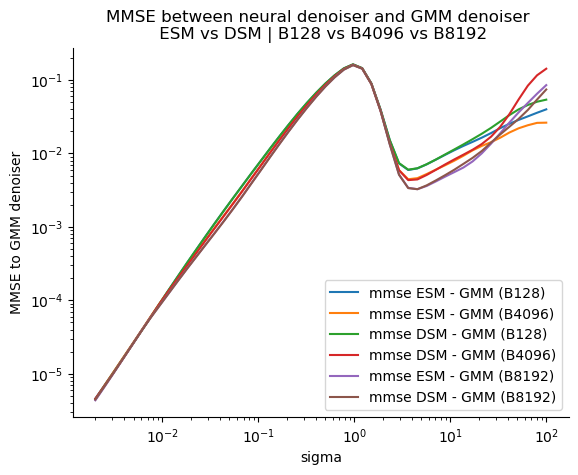

In [94]:
stats_df.plot(x="sigma", y=["mmse_esm_B128_to_gmm", "mmse_esm_B4096_to_gmm", "mmse_dsm_B128_to_gmm", "mmse_dsm_B4096_to_gmm", "mmse_esm_B8192_to_gmm", "mmse_dsm_B8192_to_gmm"], kind="line")
plt.legend(["mmse ESM - GMM (B128)", "mmse ESM - GMM (B4096)","mmse DSM - GMM (B128)", "mmse DSM - GMM (B4096)", "mmse ESM - GMM (B8192)", "mmse DSM - GMM (B8192)"])
plt.xscale("log")
plt.yscale("log")
plt.ylabel("MMSE to GMM denoiser")
plt.title("MMSE between neural denoiser and GMM denoiser \n ESM vs DSM | B128 vs B4096 vs B8192")
saveallforms(figdir, "DSM_vs_ESM_mmse2gmm_cmp_batchsize_cmp_normed_Bsize")

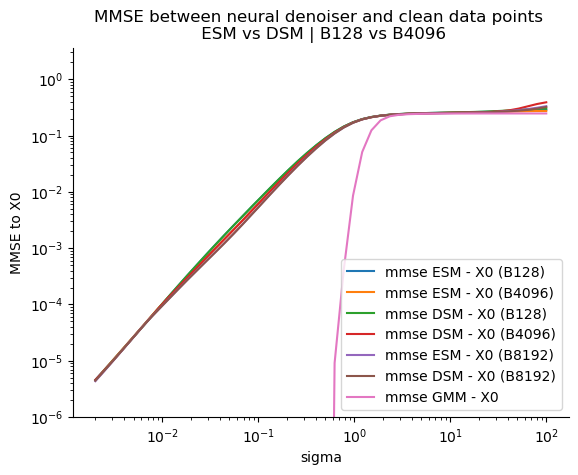

In [95]:
stats_df.plot(x="sigma", y=["mmse_esm_B128_to_x0", "mmse_esm_B4096_to_x0", "mmse_dsm_B128_to_x0", "mmse_dsm_B4096_to_x0", "mmse_esm_B8192_to_x0", "mmse_dsm_B8192_to_x0", "mmse_gmm_to_x0"], kind="line")
plt.legend(["mmse ESM - X0 (B128)", "mmse ESM - X0 (B4096)","mmse DSM - X0 (B128)", "mmse DSM - X0 (B4096)", "mmse ESM - X0 (B8192)", "mmse DSM - X0 (B8192)", "mmse GMM - X0"])
plt.xscale("log")
plt.yscale("log")
plt.ylabel("MMSE to X0")
plt.title("MMSE between neural denoiser and clean data points \n ESM vs DSM | B128 vs B4096")
plt.ylim(1E-6,None)
saveallforms(figdir, "DSM_vs_ESM_mmse2X0_cmp_batchsize_cmp_normed")

### Eval samples

In [81]:
sample_store_esm_B128 = torch.load(join(savedir, "sample_store_esm_B128.pth"))
sample_store_dsm_B128 = torch.load(join(savedir, "sample_store_dsm_B128.pth"))
sample_store_esm_B4096 = torch.load(join(savedir, "sample_store_esm_B4096.pth"))
sample_store_dsm_B4096 = torch.load(join(savedir, "sample_store_dsm_B4096.pth"))
sample_store_esm_B8192 = torch.load(join(savedir, "sample_store_esm_B8192.pth"))
sample_store_dsm_B8192 = torch.load(join(savedir, "sample_store_dsm_B8192.pth"))

/tmp/ipykernel_121594/3970553378.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_store_esm_B128 = torch.load(join(savedir, "sample_store_esm_B128.pth"))
/tmp/ipyk

In [82]:
# Load the latest generated samples from ESM and DSM training
latest_step_esm = max(sample_store_esm_B128.keys())
latest_step_dsm = max(sample_store_dsm_B128.keys())
gen_samples_esm = sample_store_esm_B128[latest_step_esm]
gen_samples_dsm = sample_store_dsm_B128[latest_step_dsm]
# Also compare the two runs for each method
gen_samples_esm2 = sample_store_esm_B4096[latest_step_esm]
gen_samples_dsm2 = sample_store_dsm_B4096[latest_step_dsm]
gen_samples_esm3 = sample_store_esm_B8192[latest_step_esm]
gen_samples_dsm3 = sample_store_dsm_B8192[latest_step_dsm]
# Compare statistics
stats_esm = compute_data_statistics_comparison(gen_samples_esm, pnts.cpu(), "ESM Generated vs Training Data:")
stats_esm2 = compute_data_statistics_comparison(gen_samples_esm2, pnts.cpu(), "ESM Run 2 Generated vs Training Data:")
stats_dsm = compute_data_statistics_comparison(gen_samples_dsm, pnts.cpu(), "DSM Generated vs Training Data:")
stats_dsm2 = compute_data_statistics_comparison(gen_samples_dsm2, pnts.cpu(), "DSM Run 2 Generated vs Training Data:")
stats_esm3 = compute_data_statistics_comparison(gen_samples_esm3, pnts.cpu(), "ESM Run 3 Generated vs Training Data:")
stats_dsm3 = compute_data_statistics_comparison(gen_samples_dsm3, pnts.cpu(), "DSM Run 3 Generated vs Training Data:")
# Create a dataframe with the statistics for comparison
stats_df = pd.DataFrame({
    'Method': ['ESM Run 1', 'ESM Run 2', 'ESM Run 3', 'DSM Run 1', 'DSM Run 2', 'DSM Run 3'],
    'Mean L2 Diff': [stats_esm['mean_diff'], stats_esm2['mean_diff'], stats_esm3['mean_diff'], 
                     stats_dsm['mean_diff'], stats_dsm2['mean_diff'], stats_dsm3['mean_diff']],
    'Mean Rel Error': [stats_esm['mean_rel_error'], stats_esm2['mean_rel_error'],
                       stats_esm3['mean_rel_error'], stats_dsm['mean_rel_error'],
                       stats_dsm2['mean_rel_error'], stats_dsm3['mean_rel_error']],
    'Cov Frob Diff': [stats_esm['cov_diff'], stats_esm2['cov_diff'], stats_esm3['cov_diff'],
                      stats_dsm['cov_diff'], stats_dsm2['cov_diff'], stats_dsm3['cov_diff']],
    'Cov Rel Error': [stats_esm['cov_rel_error'], stats_esm2['cov_rel_error'],
                      stats_esm3['cov_rel_error'], stats_dsm['cov_rel_error'],
                      stats_dsm2['cov_rel_error'], stats_dsm3['cov_rel_error']]
})

print("Data Statistics Comparison:")
print(stats_df.to_string(index=False, float_format='%.5f'))

ESM Generated vs Training Data:
Mean L2 difference: 0.257510
Mean relative error: 0.375483
Covariance Frobenius difference: 0.823227
Covariance relative error: 0.244975
--------------------------------------------------
ESM Run 2 Generated vs Training Data:
Mean L2 difference: 0.173727
Mean relative error: 0.253317
Covariance Frobenius difference: 0.837537
Covariance relative error: 0.249234
--------------------------------------------------
DSM Generated vs Training Data:
Mean L2 difference: 0.252840
Mean relative error: 0.368673
Covariance Frobenius difference: 0.856688
Covariance relative error: 0.254933
--------------------------------------------------
DSM Run 2 Generated vs Training Data:
Mean L2 difference: 0.182809
Mean relative error: 0.266559
Covariance Frobenius difference: 0.844639
Covariance relative error: 0.251347
--------------------------------------------------
ESM Run 3 Generated vs Training Data:
Mean L2 difference: 0.178283
Mean relative error: 0.259960
Covariance 

In [22]:
sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
sample_store_esm2 = torch.load(join(savedir, "sample_store_esm_2.pth"))
sample_store_dsm = torch.load(join(savedir, "sample_store_dsm.pth"))
sample_store_dsm2 = torch.load(join(savedir, "sample_store_dsm_2.pth"))
# Create frames for animation by going through different training steps
train_steps = list(sample_store_esm.keys())
# Create ESM frames
frames_esm = create_training_progress_animation(
    sample_store_esm, pnts, "Explicit Score Matching (run 1)", train_steps, sparse_slice=slice(None, None, 2)
)
frames_esm2 = create_training_progress_animation(
    sample_store_esm2, pnts, "Explicit Score Matching (run 2)", train_steps, sparse_slice=slice(None, None, 2)
)
# Create DSM frames  
frames_dsm = create_training_progress_animation(
    sample_store_dsm, pnts, "Normal Denoising Score Matching (EDM) (run 1)", train_steps, sparse_slice=slice(None, None, 2)
)
frames_dsm2 = create_training_progress_animation(
    sample_store_dsm2, pnts, "Normal Denoising Score Matching (EDM) (run 2)", train_steps, sparse_slice=slice(None, None, 2)
)
# Save the GIFs
save_training_gifs(frames_esm, "esm_training_progress_1")
save_training_gifs(frames_esm2, "esm_training_progress_2")
save_training_gifs(frames_dsm, "dsm_training_progress_1")
save_training_gifs(frames_dsm2, "dsm_training_progress_2")

print(f"Saved ESM training progress GIF to {join(figdir, 'esm_training_progress_1.gif')}")
print(f"Saved ESM training progress GIF to {join(figdir, 'esm_training_progress_2.gif')}")
print(f"Saved DSM training progress GIF to {join(figdir, 'dsm_training_progress_1.gif')}")
print(f"Saved DSM training progress GIF to {join(figdir, 'dsm_training_progress_2.gif')}")

/tmp/ipykernel_557711/121437247.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
/tmp/ipykernel_55771

Saved ESM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/esm_training_progress_1.gif
Saved ESM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/esm_training_progress_2.gif
Saved DSM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/dsm_training_progress_1.gif
Saved DSM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/dsm_training_progress_2.gif


### Measure sample memorization and generalization


In [33]:
def compute_distance2training_set(sample_store, pnts, topk=20):
    """
    Compute the distance between the generated samples and the training set.
    """
    record_step_list = list(sample_store.keys())
    # get the generated samples
    dist_collection = {}
    for step in record_step_list:
        gen_samples = sample_store[step]
        if isinstance(gen_samples, tuple):
            gen_samples = gen_samples[0]
        # compute the distance
        dists = torch.cdist(gen_samples, pnts.cpu())
        topk_dists, topk_idx = torch.topk(dists, k=topk, dim=1, largest=False)
        topk_dists_2sample, topk_idx_2sample = torch.topk(dists, k=topk, dim=0, largest=False)
        dist_collection[step] = {
            "topk_dists": topk_dists,
            "topk_idx": topk_idx,
            "topk_dists_2sample": topk_dists_2sample,
            "topk_idx_2sample": topk_idx_2sample
        }
    return dist_collection

In [24]:
sample_store_esm_B128 = torch.load(join(savedir, "sample_store_esm_B128.pth"))
sample_store_dsm_B128 = torch.load(join(savedir, "sample_store_dsm_B128.pth"))
sample_store_esm_B4096 = torch.load(join(savedir, "sample_store_esm_B4096.pth"))
sample_store_dsm_B4096 = torch.load(join(savedir, "sample_store_dsm_B4096.pth"))

/tmp/ipykernel_121594/1127059085.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_store_esm_B128 = torch.load(join(savedir, "sample_store_esm_B128.pth"))
/tmp/ipyk

In [83]:
dist_col_esm_B128 = compute_distance2training_set(sample_store_esm_B128, pnts)
dist_col_dsm_B128 = compute_distance2training_set(sample_store_dsm_B128, pnts)
dist_col_esm_B4096 = compute_distance2training_set(sample_store_esm_B4096, pnts)
dist_col_dsm_B4096 = compute_distance2training_set(sample_store_dsm_B4096, pnts)
dist_col_esm_B8192 = compute_distance2training_set(sample_store_esm_B8192, pnts)
dist_col_dsm_B8192 = compute_distance2training_set(sample_store_dsm_B8192, pnts)

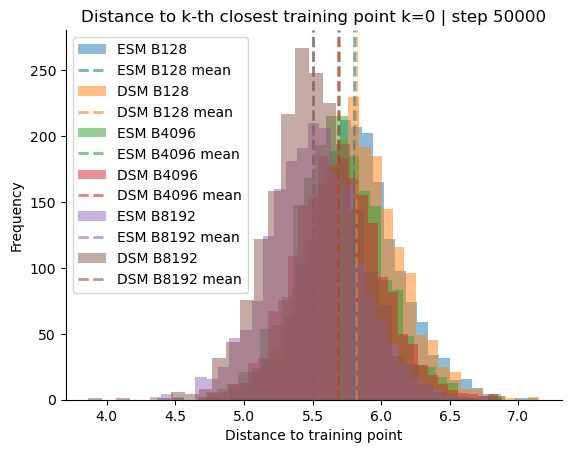

In [85]:
topk_idx = 0
step = 50000
plt.hist(dist_col_esm_B128[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="ESM B128")
plt.axvline(dist_col_esm_B128[step]['topk_dists'][:, topk_idx].mean(), color="C0", label="ESM B128 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_dsm_B128[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="DSM B128")
plt.axvline(dist_col_dsm_B128[step]['topk_dists'][:, topk_idx].mean(), color="C1", label="DSM B128 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_esm_B4096[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="ESM B4096")
plt.axvline(dist_col_esm_B4096[step]['topk_dists'][:, topk_idx].mean(), color="C2", label="ESM B4096 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_dsm_B4096[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="DSM B4096")
plt.axvline(dist_col_dsm_B4096[step]['topk_dists'][:, topk_idx].mean(), color="C3", label="DSM B4096 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_esm_B8192[250000]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="ESM B8192")
plt.axvline(dist_col_esm_B8192[250000]['topk_dists'][:, topk_idx].mean(), color="C4", label="ESM B8192 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_dsm_B8192[250000]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="DSM B8192")
plt.axvline(dist_col_dsm_B8192[250000]['topk_dists'][:, topk_idx].mean(), color="C5", label="DSM B8192 mean", alpha=0.6, linestyle="--", lw=2)
plt.xlabel("Distance to training point")
plt.ylabel("Frequency")
plt.title(f"Distance to k-th closest training point k={topk_idx} | step {step}")
plt.legend()
plt.show()

In [65]:
# shortest distance between each other 
pnts_distmat = torch.cdist(pnts, pnts)
print(pnts.std())
print(torch.nanmean(pnts_distmat))
pnts_distmat.fill_diagonal_(float('inf'))
# find the shortest distance between each other
shortest_dist = torch.min(pnts_distmat, dim=1)[0]
print(torch.nanmean(shortest_dist))

tensor(0.5000)
tensor(7.9135)
tensor(6.0618)


In [91]:
torch.nanmean(shortest_dist) / np.sqrt(128) / 2

tensor(0.2679)

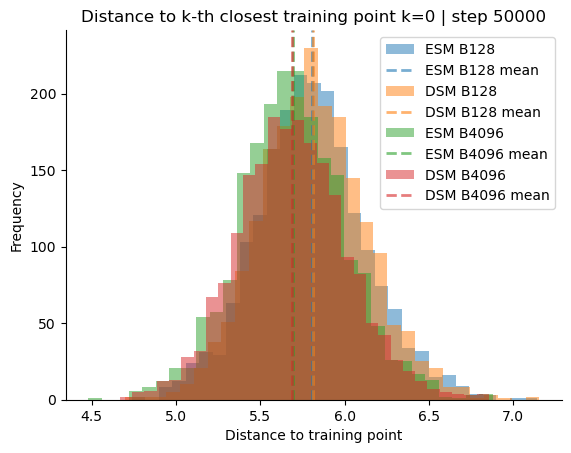

In [52]:
topk_idx = 0
step = 50000
plt.hist(dist_col_esm_B128[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="ESM B128")
plt.axvline(dist_col_esm_B128[step]['topk_dists'][:, topk_idx].mean(), color="C0", label="ESM B128 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_dsm_B128[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="DSM B128")
plt.axvline(dist_col_dsm_B128[step]['topk_dists'][:, topk_idx].mean(), color="C1", label="DSM B128 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_esm_B4096[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="ESM B4096")
plt.axvline(dist_col_esm_B4096[step]['topk_dists'][:, topk_idx].mean(), color="C2", label="ESM B4096 mean", alpha=0.6, linestyle="--", lw=2)
plt.hist(dist_col_dsm_B4096[step]['topk_dists'][:, topk_idx], bins=30, alpha=0.5, label="DSM B4096")
plt.axvline(dist_col_dsm_B4096[step]['topk_dists'][:, topk_idx].mean(), color="C3", label="DSM B4096 mean", alpha=0.6, linestyle="--", lw=2)
plt.xlabel("Distance to training point")
plt.ylabel("Frequency")
plt.title(f"Distance to k-th closest training point k={topk_idx} | step {step}")
plt.legend()
plt.show()

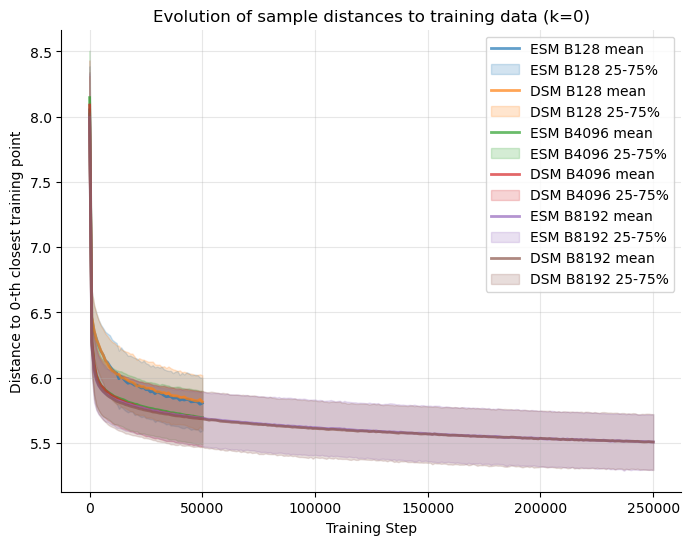

In [97]:
import pandas as pd

def extract_distance_stats_df(dist_collections, topk_idx=0):
    """Extract statistics from distance collections as a function of training step using pandas"""
    # Collect all data into a list of records
    records = []
    
    for name, dist_col in dist_collections.items():
        for step, data in dist_col.items():
            dists = data['topk_dists'][:, topk_idx]
            records.append({
                'method': name,
                'step': step,
                'mean': dists.mean().item(),
                'std': dists.std().item(),
                'q25': torch.quantile(dists, 0.25).item(),
                'q75': torch.quantile(dists, 0.75).item(),
                'q10': torch.quantile(dists, 0.10).item(),
                'q90': torch.quantile(dists, 0.90).item()
            })
    # Create DataFrame and sort by step
    df = pd.DataFrame(records)
    # df = df.sort_values('step')
    return df

# Collect all distance collections
dist_collections = {
    'ESM B128': dist_col_esm_B128,
    'DSM B128': dist_col_dsm_B128,
    'ESM B4096': dist_col_esm_B4096,
    'DSM B4096': dist_col_dsm_B4096,
    'ESM B8192': dist_col_esm_B8192,
    'DSM B8192': dist_col_dsm_B8192,
}
topk_idx = 0
dist_stats_df = extract_distance_stats_df(dist_collections, topk_idx=topk_idx)

# Plot the curves
plt.figure(figsize=(8, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
methods = dist_stats_df['method'].unique()
for i, method in enumerate(methods):
    method_df = dist_stats_df[dist_stats_df['method'] == method]
    # Plot mean curve
    plt.plot(method_df['step'], method_df['mean'], f'{colors[i]}-', 
             label=f'{method} mean', linewidth=2, alpha=0.7)
    # Plot quantile band
    plt.fill_between(method_df['step'], method_df['q25'], method_df['q75'], 
                     alpha=0.2, color=colors[i], label=f'{method} 25-75%')

plt.xlabel('Training Step')
plt.ylabel(f'Distance to {topk_idx}-th closest training point')
plt.title(f'Evolution of sample distances to training data (k={topk_idx})')
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

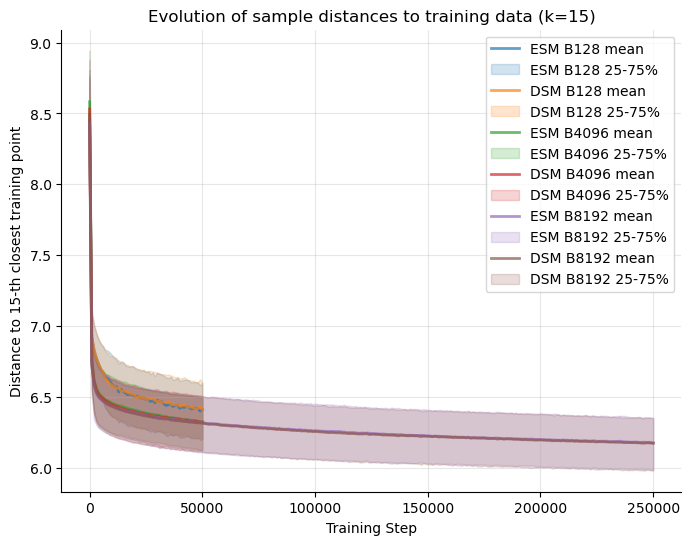

In [ ]:

# Collect all distance collections
dist_collections = {
    'ESM B128': dist_col_esm_B128,
    'DSM B128': dist_col_dsm_B128,
    'ESM B4096': dist_col_esm_B4096,
    'DSM B4096': dist_col_dsm_B4096,
    'ESM B8192': dist_col_esm_B8192,
    'DSM B8192': dist_col_dsm_B8192,
}
topk_idx = 15
dist_stats_df = extract_distance_stats_df(dist_collections, topk_idx=topk_idx)

# Plot the curves
plt.figure(figsize=(8, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
methods = dist_stats_df['method'].unique()
for i, method in enumerate(methods):
    method_df = dist_stats_df[dist_stats_df['method'] == method]
    # Plot mean curve
    plt.plot(method_df['step'], method_df['mean'], f'{colors[i]}-', 
             label=f'{method} mean', linewidth=2, alpha=0.7)
    # Plot quantile band
    plt.fill_between(method_df['step'], method_df['q25'], method_df['q75'], 
                     alpha=0.2, color=colors[i], label=f'{method} 25-75%')

plt.xlabel('Training Step')
plt.ylabel(f'Distance to {topk_idx}-th closest training point')
plt.title(f'Evolution of sample distances to training data (k={topk_idx})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

11.313708498984761

### Phase transition of one hot softmax

In [ ]:
# shortest distance between each other 
pnts_distmat = torch.cdist(pnts, pnts)
print(pnts.std())
print(torch.nanmean(pnts_distmat))
pnts_distmat.fill_diagonal_(float('inf'))
# find the shortest distance between each other
shortest_dist = torch.min(pnts_distmat, dim=1)[0]
print(torch.nanmean(shortest_dist))

tensor(0.5000)
tensor(7.9135)
tensor(6.0618)


In [ ]:
Npnts = len(pnts)
mean_mindist = torch.nanmean(shortest_dist)
EPS = 0.001
sigma_transition = mean_mindist / np.sqrt(2 * np.log(Npnts / EPS))
print(sigma_transition)

tensor(1.1244)


### Measure Liftzchiz constant

In [114]:
sigma = 1
repeat_times = 4
pnts_rep = pnts.repeat(repeat_times, 1)
noisd_pnts = pnts_rep + torch.randn_like(pnts_rep) * sigma
gmm_denoised = delta_GMM_denoiser(noisd_pnts, pnts, sigma)

In [115]:
# Find the closest K pairs of points among noisd_pnts
K = 100  # Number of closest pairs to find
noisd_distmat = torch.cdist(noisd_pnts, noisd_pnts)
noisd_distmat.fill_diagonal_(float('inf'))  # Exclude self-distances
# Get the K smallest distances and their indices
flat_distances = noisd_distmat.flatten()
k_smallest_distances, k_smallest_indices = torch.topk(flat_distances, K, largest=False)
# Convert flat indices back to 2D indices
rows = k_smallest_indices // noisd_pnts.shape[0]
cols = k_smallest_indices % noisd_pnts.shape[0]

print(f"Found {K} closest pairs of points")
print(f"Smallest distance: {k_smallest_distances[0]:.4f}")
print(f"Largest distance in K smallest: {k_smallest_distances[-1]:.4f}")
print(f"First few pairs (indices): {list(zip(rows[:5].tolist(), cols[:5].tolist()))}")

Found 100 closest pairs of points
Smallest distance: 12.1537
Largest distance in K smallest: 12.8069
First few pairs (indices): [(4879, 6927), (6927, 4879), (4156, 28), (28, 4156), (5276, 3300)]


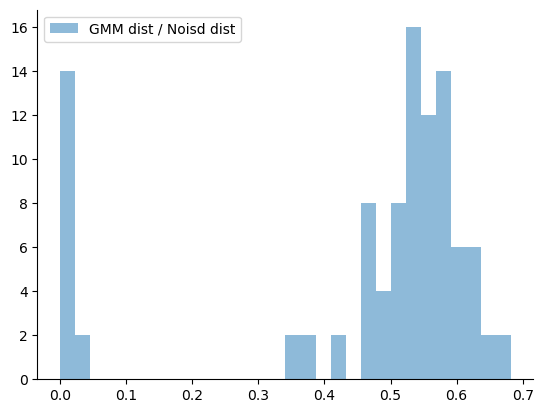

In [118]:
dist_x_vec = []
dist_x_gmm_vec = []
for pairi in range(len(rows)):
    idxi, idxj = rows[pairi], cols[pairi]
    x_dist = torch.norm(noisd_pnts[idxi] - noisd_pnts[idxj])
    x_dist_gmm = torch.norm(gmm_denoised[idxi] - gmm_denoised[idxj])
    dist_x_vec.append(x_dist)
    dist_x_gmm_vec.append(x_dist_gmm)

dist_x_vec = torch.stack(dist_x_vec)
dist_x_gmm_vec = torch.stack(dist_x_gmm_vec)
plt.hist(dist_x_gmm_vec / dist_x_vec, bins=30, alpha=0.5, label="GMM dist / Noisd dist")
plt.legend()
plt.show()

Found 1000 closest pairs of points
Smallest distance: 3.7655
Largest distance in K smallest: 4.2677
First few pairs (indices): [(19, 6163), (6163, 19), (2816, 6912), (6912, 2816), (2226, 4274)]


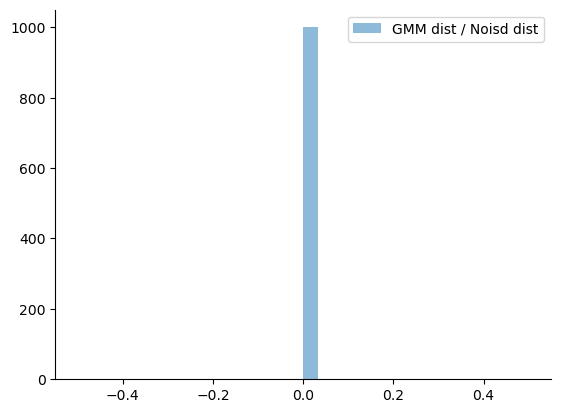

In [ ]:
sigma = 0.3
repeat_times = 4
pnts_rep = pnts.repeat(repeat_times, 1)
noisd_pnts = pnts_rep + torch.randn_like(pnts_rep) * sigma
gmm_denoised = delta_GMM_denoiser(noisd_pnts, pnts, sigma)
# Find the closest K pairs of points among noisd_pnts
K = 2000  # Number of closest pairs to find
noisd_distmat = torch.cdist(noisd_pnts, noisd_pnts)
noisd_distmat.fill_diagonal_(float('inf'))  # Exclude self-distances
# Get the K smallest distances and their indices
flat_distances = noisd_distmat.flatten()
k_smallest_distances, k_smallest_indices = torch.topk(flat_distances, K, largest=False)
# Convert flat indices back to 2D indices
rows = k_smallest_indices // noisd_pnts.shape[0]
cols = k_smallest_indices % noisd_pnts.shape[0]

print(f"Found {K} closest pairs of points")
print(f"Smallest distance: {k_smallest_distances[0]:.4f}")
print(f"Largest distance in K smallest: {k_smallest_distances[-1]:.4f}")
print(f"First few pairs (indices): {list(zip(rows[:5].tolist(), cols[:5].tolist()))}")
dist_x_vec = []
dist_x_gmm_vec = []
for pairi in range(len(rows)):
    idxi, idxj = rows[pairi], cols[pairi]
    x_dist = torch.norm(noisd_pnts[idxi] - noisd_pnts[idxj])
    x_dist_gmm = torch.norm(gmm_denoised[idxi] - gmm_denoised[idxj])
    dist_x_vec.append(x_dist)
    dist_x_gmm_vec.append(x_dist_gmm)

dist_x_vec = torch.stack(dist_x_vec)
dist_x_gmm_vec = torch.stack(dist_x_gmm_vec)
plt.hist(dist_x_gmm_vec / dist_x_vec, bins=30, alpha=0.5, label="GMM dist / Noisd dist")
plt.legend()
plt.show()

In [143]:
figdir

'/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_dim_batchsize_cmp'

In [177]:

repeat_times = 4
pnts_rep = pnts.repeat(repeat_times, 1)
pair_stats_col = []
for sigma in [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 4.0, 8.0, 12.0, 20.0]:
    noisd_pnts = pnts_rep + torch.randn_like(pnts_rep) * sigma
    gmm_denoised = delta_GMM_denoiser(noisd_pnts, pnts, sigma)
    # Find the closest K pairs of points among noisd_pnts
    K = 2000  # Number of closest pairs to find
    noisd_distmat = torch.cdist(noisd_pnts, noisd_pnts)
    noisd_distmat.fill_diagonal_(float('inf'))  # Exclude self-distances
    # Get the K smallest distances and their indices
    flat_distances = noisd_distmat.flatten()
    k_smallest_distances, k_smallest_indices = torch.topk(flat_distances, K, largest=False)
    # Convert flat indices back to 2D indices
    rows = k_smallest_indices // noisd_pnts.shape[0]
    cols = k_smallest_indices % noisd_pnts.shape[0]

    print(f"Found {K} closest pairs of points")
    print(f"Smallest distance: {k_smallest_distances[0]:.4f}")
    print(f"Largest distance in K smallest: {k_smallest_distances[-1]:.4f}")
    print(f"First few pairs (indices): {list(zip(rows[:5].tolist(), cols[:5].tolist()))}")
    dist_x_vec = []
    dist_x0_vec = []
    dist_denoised_x_vec = []
    for pairi in range(len(rows)):
        idxi, idxj = rows[pairi], cols[pairi]
        x_dist = torch.norm(noisd_pnts[idxi] - noisd_pnts[idxj])
        x0_dist = torch.norm(pnts_rep[idxi] - pnts_rep[idxj])
        denoised_x_dist = torch.norm(gmm_denoised[idxi] - gmm_denoised[idxj])
        dist_x_vec.append(x_dist)
        dist_x0_vec.append(x0_dist)
        dist_denoised_x_vec.append(denoised_x_dist)

    dist_x_vec = torch.stack(dist_x_vec)
    dist_x0_vec = torch.stack(dist_x0_vec)
    dist_denoised_x_vec = torch.stack(dist_denoised_x_vec)
    pair_stats_col.append(pd.DataFrame({"sigma": sigma, "dist_x": dist_x_vec, "dist_x0": dist_x0_vec, "dist_denoised_x": dist_denoised_x_vec, 
                                        "denoised_x_slope": dist_denoised_x_vec / dist_x_vec, "x0_x_slope": dist_x0_vec / dist_x_vec}))
    
pair_stats_df = pd.concat(pair_stats_col)
pair_stats_df.to_csv(join(figdir, "gmm_denoiser_pair_Lipschitz_slope_df.csv"), index=False)

Found 2000 closest pairs of points
Smallest distance: 0.0585
Largest distance in K smallest: 0.0729
First few pairs (indices): [(7445, 3349), (3349, 7445), (7463, 5415), (5415, 7463), (900, 4996)]
Found 2000 closest pairs of points
Smallest distance: 0.1212
Largest distance in K smallest: 0.1456
First few pairs (indices): [(3684, 1636), (1636, 3684), (169, 2217), (2217, 169), (455, 6599)]
Found 2000 closest pairs of points
Smallest distance: 0.2479
Largest distance in K smallest: 0.2914
First few pairs (indices): [(4925, 2877), (2877, 4925), (1784, 5880), (5880, 1784), (4262, 166)]
Found 2000 closest pairs of points
Smallest distance: 0.5977
Largest distance in K smallest: 0.7293
First few pairs (indices): [(6008, 3960), (3960, 6008), (5894, 7942), (7942, 5894), (6467, 2371)]
Found 2000 closest pairs of points
Smallest distance: 1.2497
Largest distance in K smallest: 1.4579
First few pairs (indices): [(5448, 7496), (7496, 5448), (2968, 920), (920, 2968), (321, 4417)]
Found 2000 closest

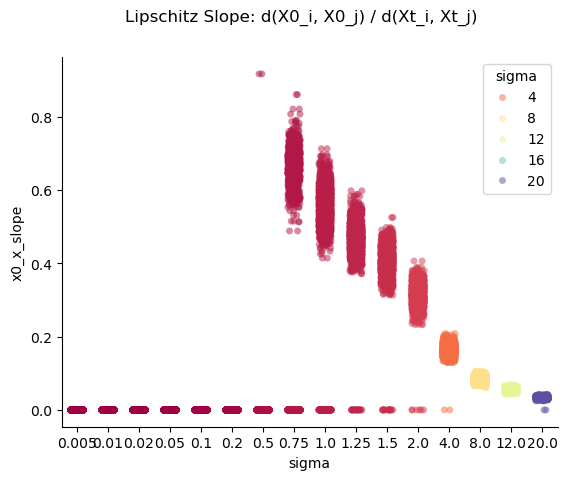

In [180]:
sns.stripplot(data=pair_stats_df, x="sigma", y="x0_x_slope", hue="sigma", jitter=0.2, alpha=0.5, palette="Spectral")
# plt.xscale("log")
# plt.yscale("log")
plt.suptitle("Lipschitz Slope: d(X0_i, X0_j) / d(Xt_i, Xt_j)")
saveallforms(figdir, "gmm_denoiser_pair_Lipschitz_slope_stripplot_x0_x_slope")
plt.show()

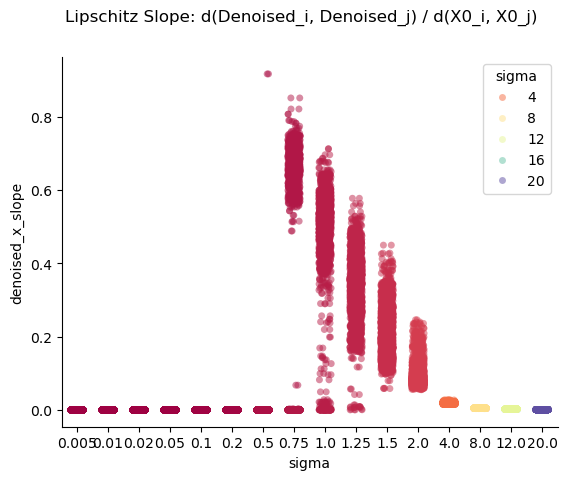

In [181]:
sns.stripplot(data=pair_stats_df, x="sigma", y="denoised_x_slope", hue="sigma", jitter=0.2, alpha=0.5, palette="Spectral")
# plt.xscale("log")
# plt.yscale("log")
plt.suptitle("Lipschitz Slope: d(Denoised_i, Denoised_j) / d(X0_i, X0_j)")
saveallforms(figdir, "gmm_denoiser_pair_Lipschitz_slope_stripplot_denoised_x_slope")
plt.show()

<Axes: xlabel='gmm_x_slope', ylabel='Count'>

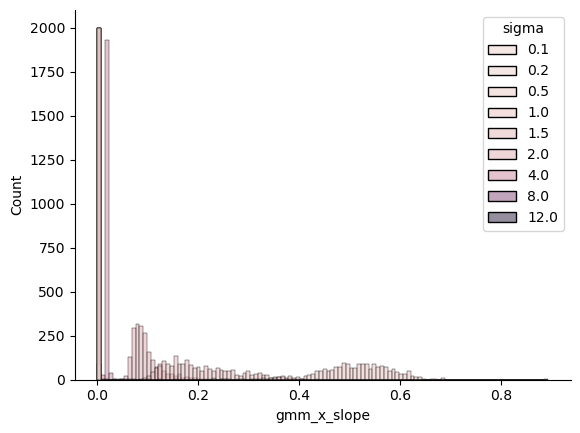

In [135]:
sns.histplot(data=pair_stats_df, x="gmm_x_slope", hue="sigma")

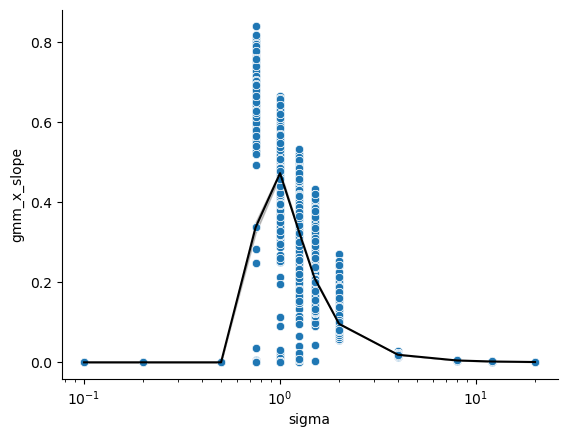

In [157]:
sns.lineplot(data=pair_stats_df, x="sigma", y="gmm_x_slope", errorbar=('ci', 95), color="k")
sns.scatterplot(data=pair_stats_df, x="sigma", y="gmm_x_slope", )
plt.xscale("log")
# plt.yscale("log")
saveallforms(figdir, "gmm_denoiser_pair_Lipschitz_slope_lineplot")

### Lipfchitz of actual NN

In [191]:
model_precd_dsm = torch.load(join(savedir, f"model_precd_dsm_B8192.pth"))
model_name = "dsm_B128"
model_precd_dsm = torch.load(join(savedir, f"model_precd_{model_name}.pth"))
model_precd_dsm.eval()
model_precd_dsm.to(device);

/tmp/ipykernel_121594/643880507.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_precd_dsm = torch.load(join(savedir, f"model_precd_dsm_B8192.pth"))
/tmp/ipykernel_

In [196]:
from inspect import getsource
print(getsource(model_precd_dsm.forward))

    def forward(self, X, sigma, cond=None, ):
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        model_out = self.model(c_in * X, c_noise, cond=cond)
        return c_skip * X + c_out * model_out



In [192]:
repeat_times = 4
pnts_rep = pnts.repeat(repeat_times, 1)
pair_stats_col = []
for sigma in [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 4.0, 8.0, 12.0, 20.0]:
    noisd_pnts = pnts_rep + torch.randn_like(pnts_rep) * sigma
    with torch.no_grad():
        gmm_denoised = model_precd_dsm(noisd_pnts.to(device),  sigma * torch.ones(noisd_pnts.shape[0], 1, device=device)).cpu()
    # Find the closest K pairs of points among noisd_pnts
    K = 2000  # Number of closest pairs to find
    noisd_distmat = torch.cdist(noisd_pnts, noisd_pnts)
    noisd_distmat.fill_diagonal_(float('inf'))  # Exclude self-distances
    # Get the K smallest distances and their indices
    flat_distances = noisd_distmat.flatten()
    k_smallest_distances, k_smallest_indices = torch.topk(flat_distances, K, largest=False)
    # Convert flat indices back to 2D indices
    rows = k_smallest_indices // noisd_pnts.shape[0]
    cols = k_smallest_indices % noisd_pnts.shape[0]

    print(f"Found {K} closest pairs of points")
    print(f"Smallest distance: {k_smallest_distances[0]:.4f}")
    print(f"Largest distance in K smallest: {k_smallest_distances[-1]:.4f}")
    print(f"First few pairs (indices): {list(zip(rows[:5].tolist(), cols[:5].tolist()))}")
    dist_x_vec = []
    dist_x0_vec = []
    dist_denoised_x_vec = []
    for pairi in range(len(rows)):
        idxi, idxj = rows[pairi], cols[pairi]
        x_dist = torch.norm(noisd_pnts[idxi] - noisd_pnts[idxj])
        x0_dist = torch.norm(pnts_rep[idxi] - pnts_rep[idxj])
        denoised_x_dist = torch.norm(gmm_denoised[idxi] - gmm_denoised[idxj])
        dist_x_vec.append(x_dist)
        dist_x0_vec.append(x0_dist)
        dist_denoised_x_vec.append(denoised_x_dist)

    dist_x_vec = torch.stack(dist_x_vec)
    dist_x0_vec = torch.stack(dist_x0_vec)
    dist_denoised_x_vec = torch.stack(dist_denoised_x_vec)
    pair_stats_col.append(pd.DataFrame({"sigma": sigma, "dist_x": dist_x_vec, "dist_x0": dist_x0_vec, "dist_denoised_x": dist_denoised_x_vec, 
                                        "denoised_x_slope": dist_denoised_x_vec / dist_x_vec, "x0_x_slope": dist_x0_vec / dist_x_vec}))
    
pair_stats_df = pd.concat(pair_stats_col)
pair_stats_df.to_csv(join(figdir, f"dnn_{model_name}_denoiser_pair_Lipschitz_slope_df.csv"), index=False)

Found 2000 closest pairs of points
Smallest distance: 0.0603
Largest distance in K smallest: 0.0728
First few pairs (indices): [(7375, 3279), (3279, 7375), (6915, 2819), (2819, 6915), (3309, 7405)]
Found 2000 closest pairs of points
Smallest distance: 0.1262
Largest distance in K smallest: 0.1459
First few pairs (indices): [(6042, 1946), (1946, 6042), (5153, 7201), (7201, 5153), (2642, 4690)]
Found 2000 closest pairs of points
Smallest distance: 0.2445
Largest distance in K smallest: 0.2924
First few pairs (indices): [(6079, 1983), (1983, 6079), (1059, 3107), (3107, 1059), (5889, 7937)]
Found 2000 closest pairs of points
Smallest distance: 0.6021
Largest distance in K smallest: 0.7292
First few pairs (indices): [(7648, 1504), (1504, 7648), (4678, 2630), (2630, 4678), (3465, 5513)]
Found 2000 closest pairs of points
Smallest distance: 1.2524
Largest distance in K smallest: 1.4581
First few pairs (indices): [(724, 6868), (6868, 724), (4588, 492), (492, 4588), (4176, 6224)]
Found 2000 clo

In [193]:
pair_stats_df.query("sigma == 0.01")

,sigma,dist_x,dist_x0,dist_denoised_x,denoised_x_slope,x0_x_slope
0,0.01,0.126263,0.0,0.125583,0.994618,0.0
1,0.01,0.126263,0.0,0.125583,0.994618,0.0
2,0.01,0.127060,0.0,0.126188,0.993138,0.0
3,0.01,0.127060,0.0,0.126188,0.993138,0.0
4,0.01,0.127165,0.0,0.126176,0.992226,0.0
...,...,...,...,...,...,...
1995,0.01,0.145811,0.0,0.144977,0.994280,0.0
1996,0.01,0.145854,0.0,0.144675,0.991912,0.0
1997,0.01,0.145879,0.0,0.145022,0.994122,0.0
1998,0.01,0.145858,0.0,0.145085,0.994705,0.0


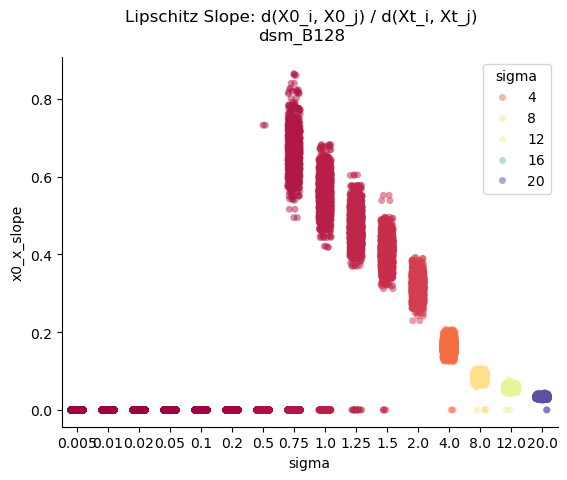

In [194]:
sns.stripplot(data=pair_stats_df, x="sigma", y="x0_x_slope", hue="sigma", jitter=0.2, alpha=0.5, palette="Spectral")
# plt.xscale("log")
# plt.yscale("log")
plt.suptitle(f"Lipschitz Slope: d(X0_i, X0_j) / d(Xt_i, Xt_j)\n{model_name}")
# saveallforms(figdir, f"dnn_{model_name}_denoiser_pair_Lipschitz_slope_stripplot_denoised_x_slope")
plt.show()

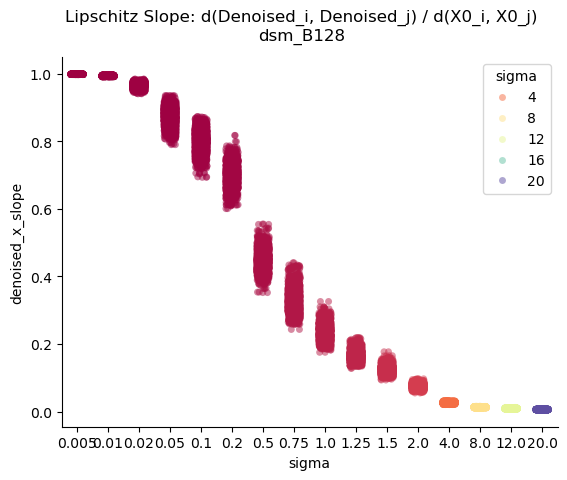

In [195]:
sns.stripplot(data=pair_stats_df, x="sigma", y="denoised_x_slope", hue="sigma", jitter=0.2, alpha=0.5, palette="Spectral")
# plt.xscale("log")
# plt.yscale("log")
plt.suptitle(f"Lipschitz Slope: d(Denoised_i, Denoised_j) / d(X0_i, X0_j)\n{model_name}")
saveallforms(figdir, f"dnn_{model_name}_denoiser_pair_Lipschitz_slope_stripplot_denoised_x_slope")
plt.show()

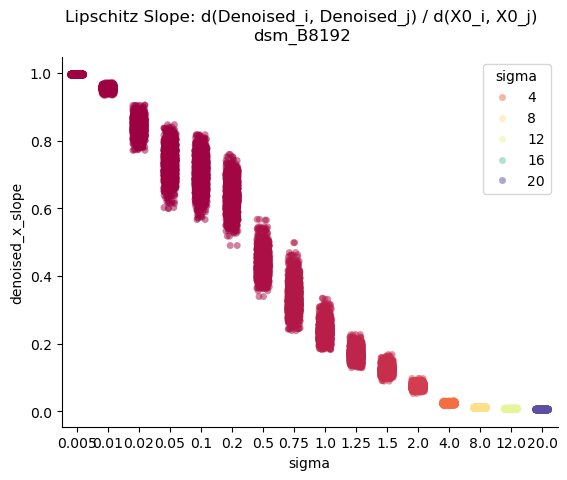

In [189]:
sns.stripplot(data=pair_stats_df, x="sigma", y="denoised_x_slope", hue="sigma", jitter=0.2, alpha=0.5, palette="Spectral")
# plt.xscale("log")
# plt.yscale("log")
plt.suptitle(f"Lipschitz Slope: d(Denoised_i, Denoised_j) / d(X0_i, X0_j)\n{model_name}")
saveallforms(figdir, f"dnn_{model_name}_denoiser_pair_Lipschitz_slope_stripplot_denoised_x_slope")
plt.show()

### Score field differences (2d case)

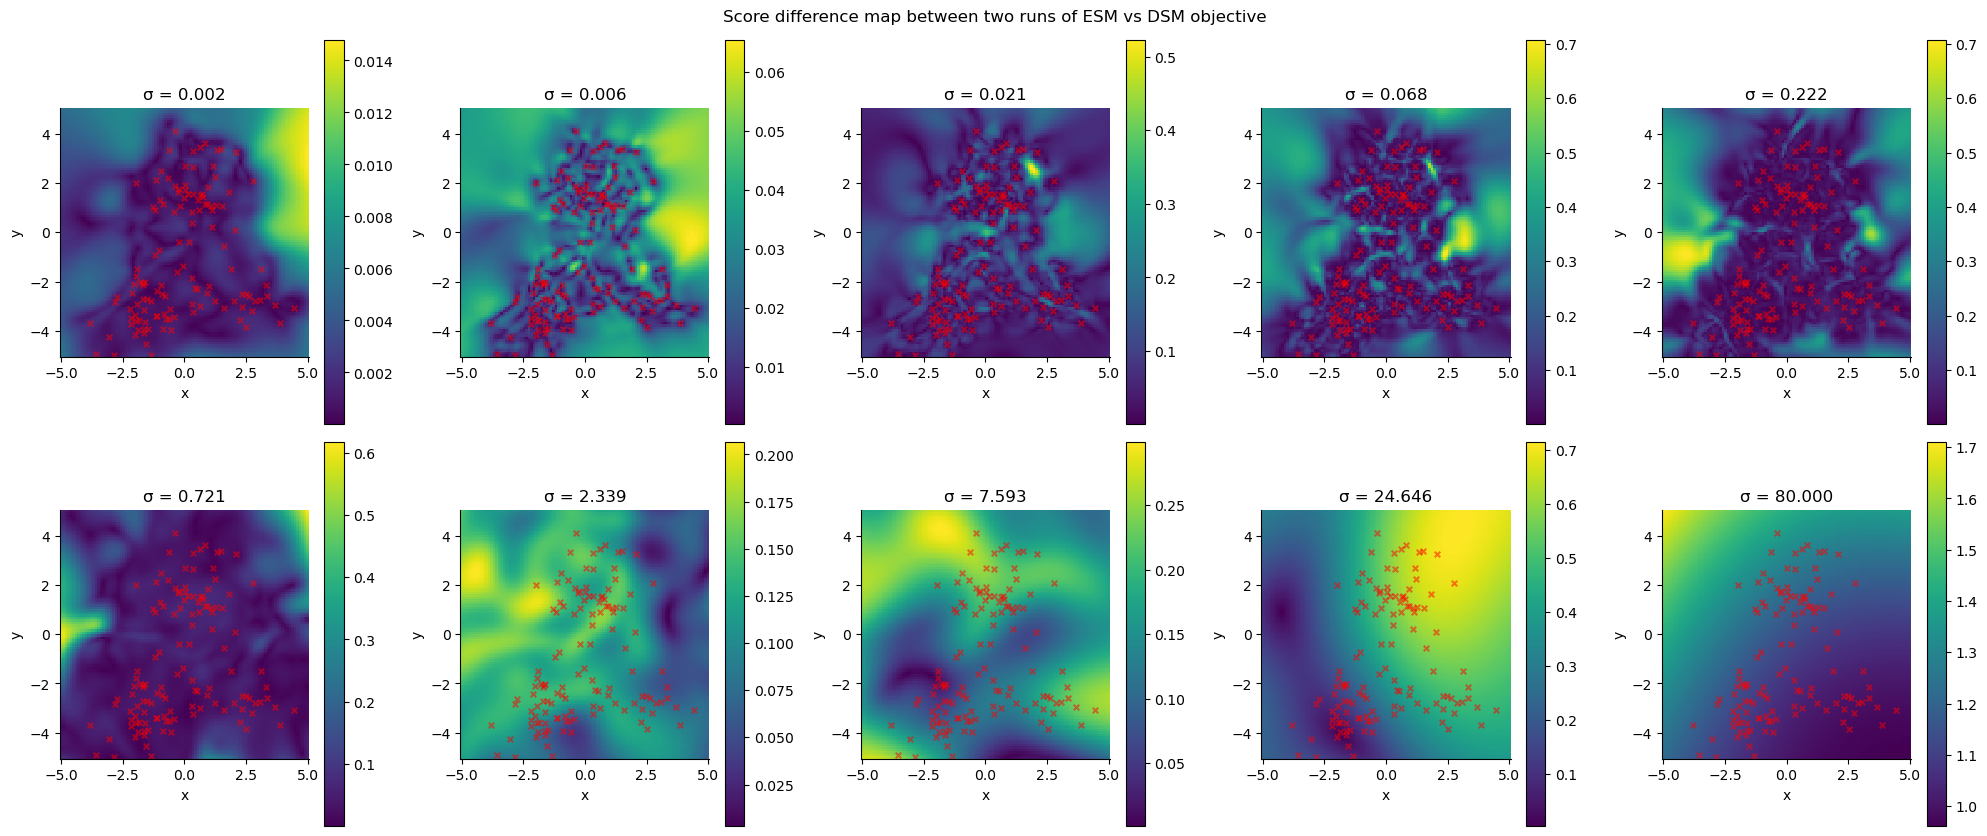

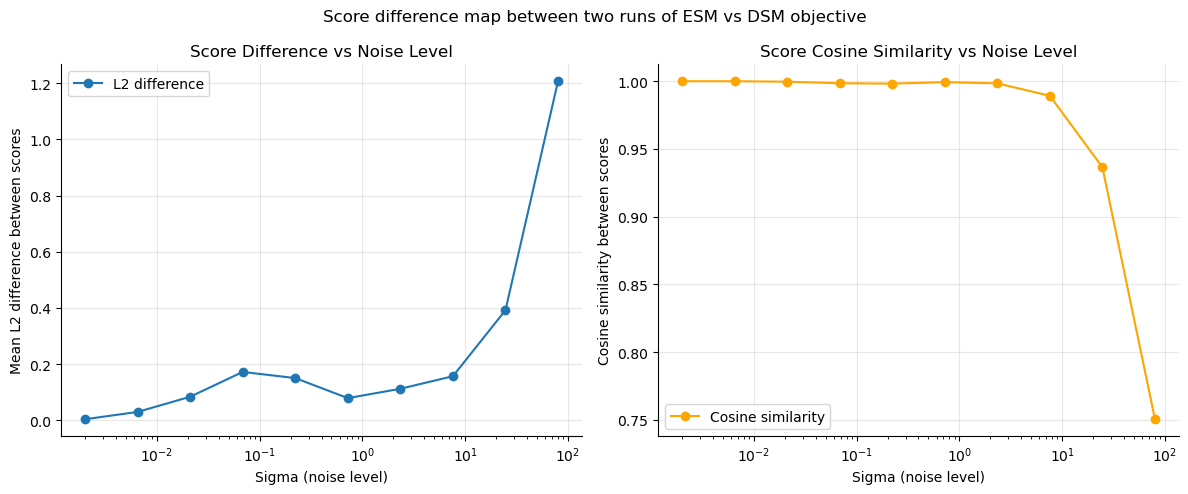

Average cosine similarity across noise levels: 0.9670
Average L2 difference across noise levels: 0.2384


In [ ]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
cosine_similarities_at_each_point_col = []
model_precd_esm.eval()
model_precd_dsm.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_esm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_dsm(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # cosine similarity at each point
        cosine_similarities_at_each_point = torch.nn.functional.cosine_similarity(score1, score2, dim=1)
        cosine_similarities_at_each_point_col.append(cosine_similarities_at_each_point)
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 5, figsize=(20, 8.5))
axes = axes.flatten()
# Select a few different noise levels to show
for i, idx in enumerate(range(len(sigma_values))):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of ESM vs DSM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of ESM vs DSM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:716.)
  sigma[sigma == 0] = self.sigma_min
/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/cuda/Indexing.cu:1561.)
  sigma[sigma == 0] = self.sigma_min


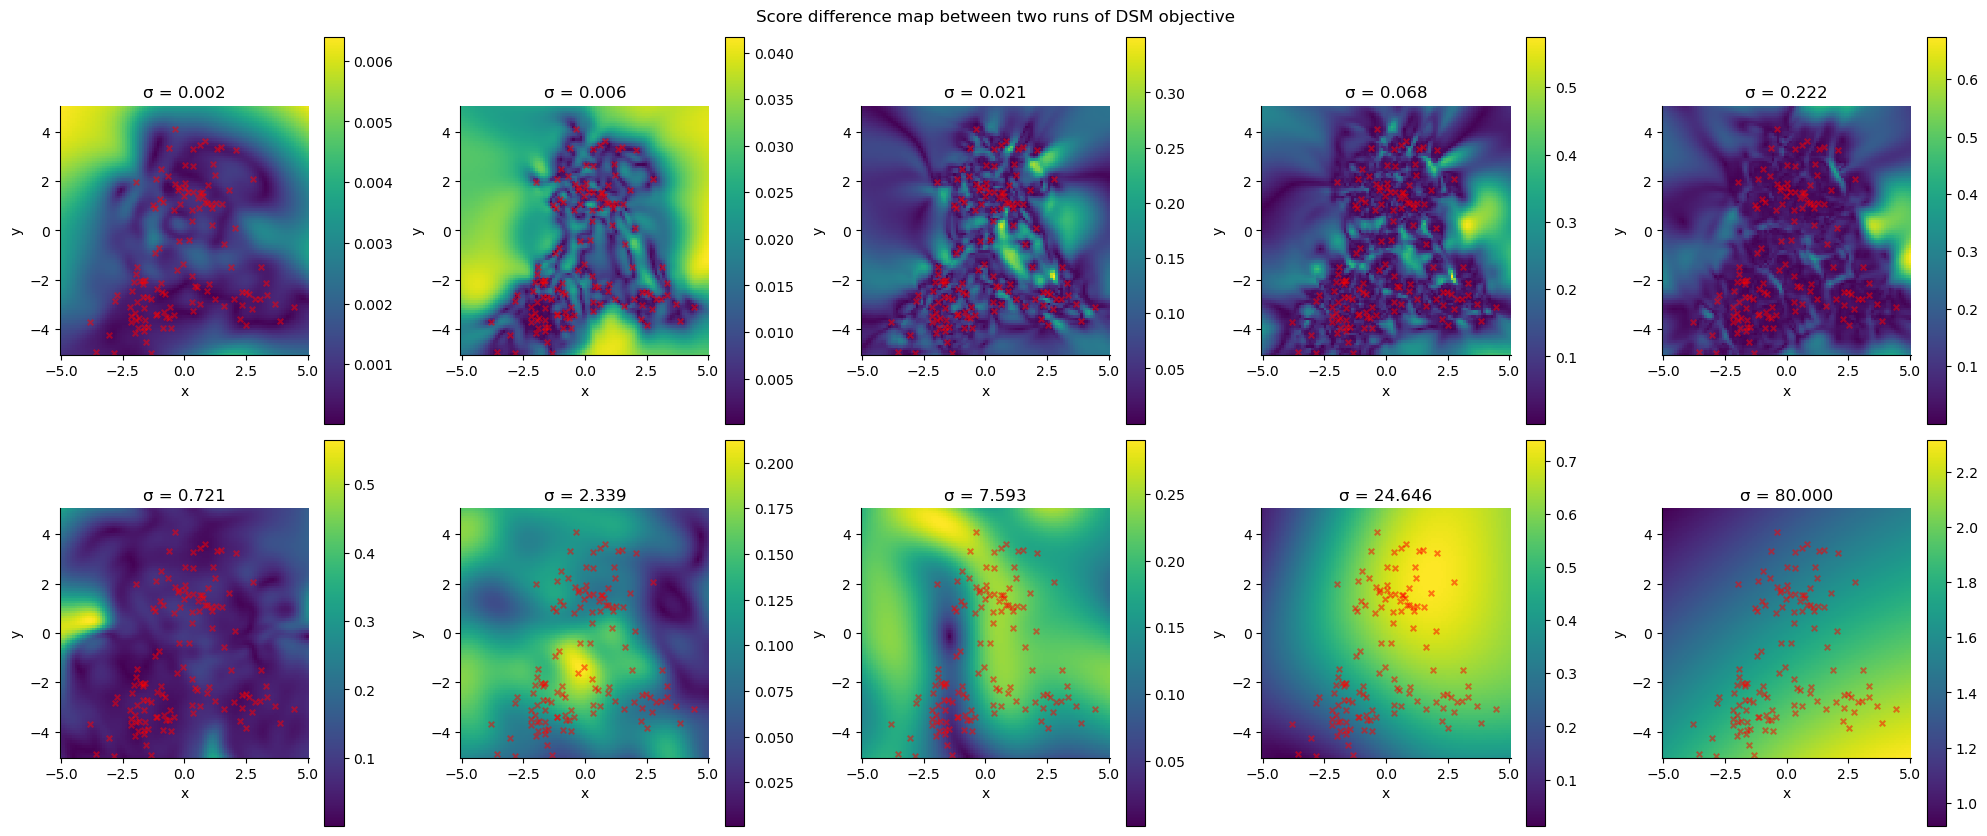

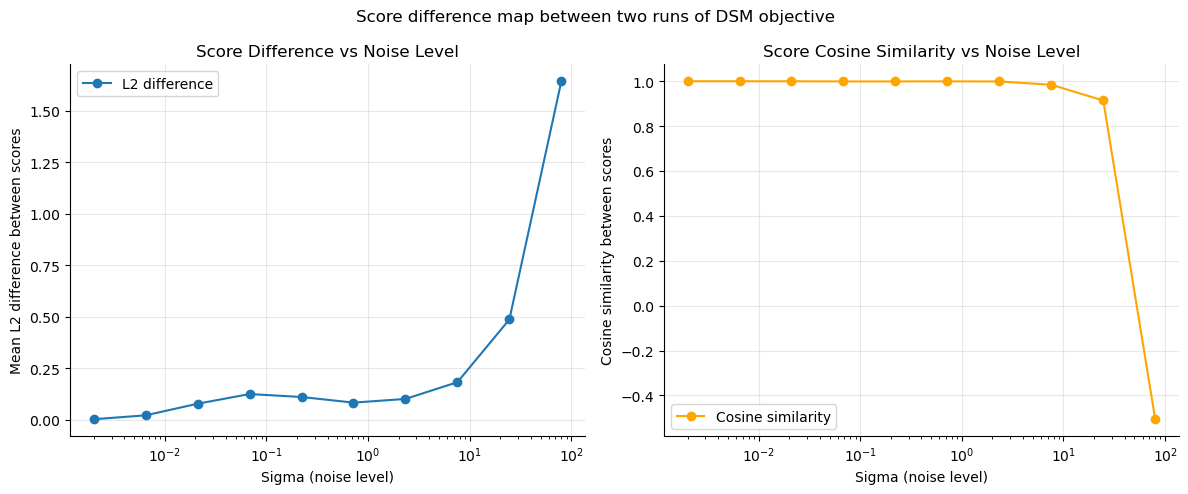

Average cosine similarity across noise levels: 0.8388
Average L2 difference across noise levels: 0.2829


In [ ]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
model_precd_dsm.eval()
model_precd_dsm2.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_dsm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_dsm2(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 5, figsize=(20, 8.5))
axes = axes.flatten()
# Select a few different noise levels to show
for i, idx in enumerate(range(len(sigma_values))):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of DSM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of DSM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


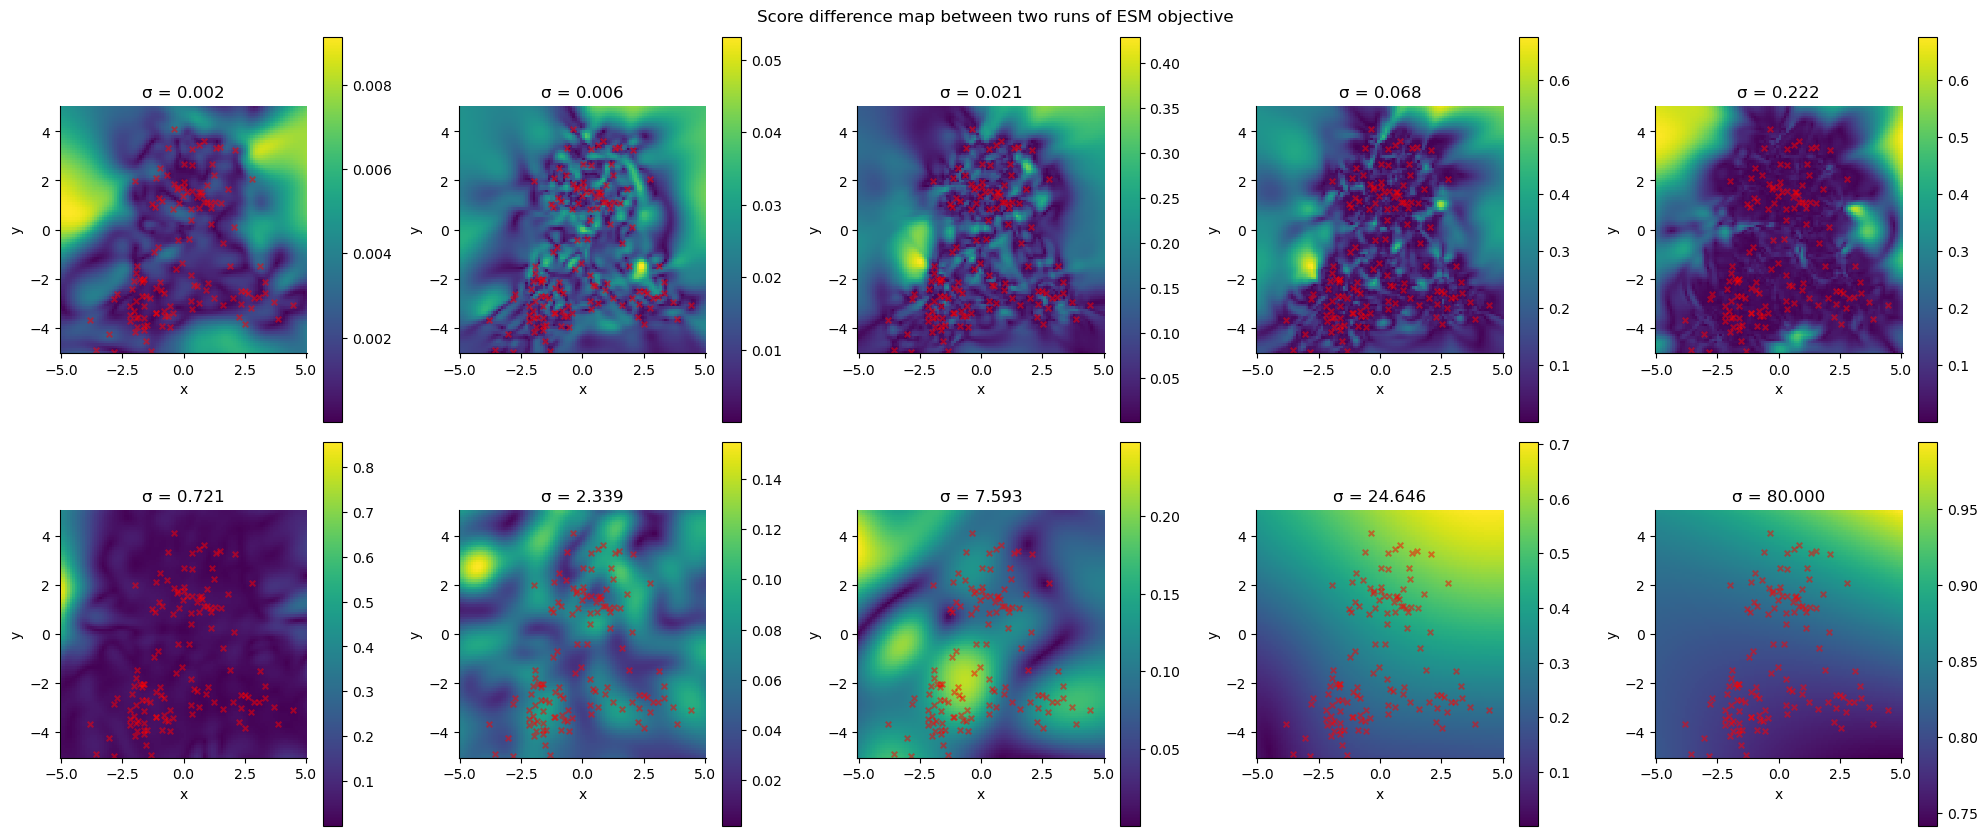

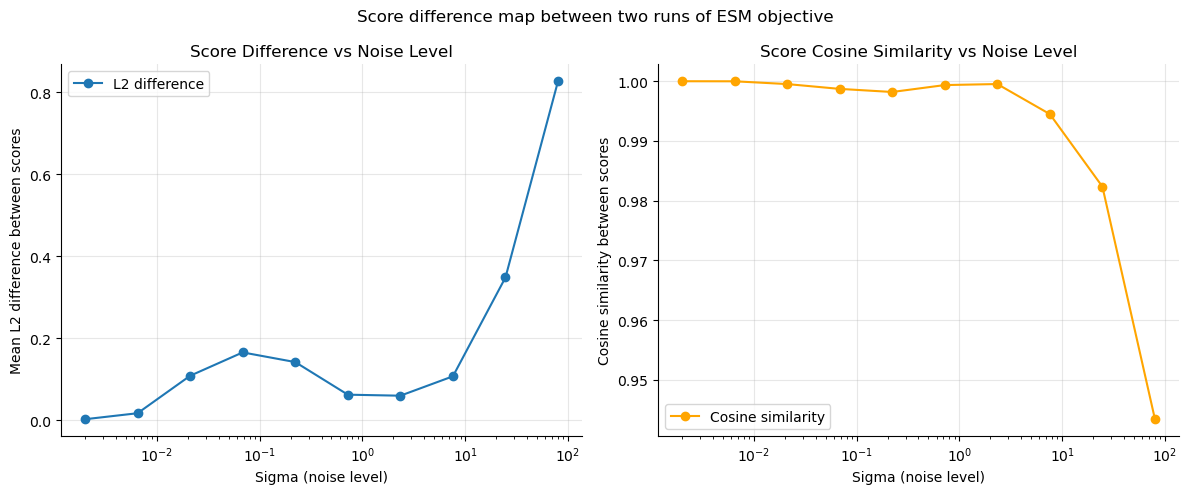

Average cosine similarity across noise levels: 0.9916
Average L2 difference across noise levels: 0.1844


In [ ]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
cosine_similarities_at_each_point_col = []
model_precd_esm.eval()
model_precd_esm2.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_esm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_esm2(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # cosine similarity at each point
        cosine_similarities_at_each_point = torch.nn.functional.cosine_similarity(score1, score2, dim=1)
        cosine_similarities_at_each_point_col.append(cosine_similarities_at_each_point)
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 5, figsize=(20, 8.5))
axes = axes.flatten()
# Select a few different noise levels to show
for i, idx in enumerate(range(len(sigma_values))):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of ESM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of ESM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


### Old code

In [35]:
record_step_list = list(sample_store_esm.keys())
# Collect all distance data for each method
min_dists_esm_all = []  # List of tensors, one per training step
min_dists_dsm_all = []
min_dists_2sample_esm_all = []  # Training data to samples
min_dists_2sample_dsm_all = []

for train_step in record_step_list:
    samples_esm, _, _, _ = sample_store_esm[train_step]
    samples_dsm, _, _, _ = sample_store_dsm[train_step]
    
    # Measure distance to closest training datapoint
    dists_esm = torch.cdist(samples_esm, pnts.cpu())  # [n_samples, n_train]
    min_dists_esm = dists_esm.min(dim=1)[0]  # Distance to closest training point for each sample
    min_dists_2sample_esm = dists_esm.min(dim=0)[0]  # Distance to closest sample for each training point
    
    dists_dsm = torch.cdist(samples_dsm, pnts.cpu())  # [n_samples, n_train]
    min_dists_dsm = dists_dsm.min(dim=1)[0]  # Distance to closest training point for each sample
    min_dists_2sample_dsm = dists_dsm.min(dim=0)[0]  # Distance to closest sample for each training point
    
    # Store raw distance data
    min_dists_esm_all.append(min_dists_esm)
    min_dists_dsm_all.append(min_dists_dsm)
    min_dists_2sample_esm_all.append(min_dists_2sample_esm)
    min_dists_2sample_dsm_all.append(min_dists_2sample_dsm)

# Compute statistics post-hoc
def compute_stats(dists_list):
    """Compute statistics for a list of distance tensors"""
    stats = []
    for dists in dists_list:
        stats.append({
            'mean': dists.mean().item(),
            'std': dists.std().item(),
            'min': dists.min().item(),
            'max': dists.max().item(),
            'q25': torch.quantile(dists, 0.25).item(),
            'q75': torch.quantile(dists, 0.75).item()
        })
    return stats

min_dists_esm_stats = compute_stats(min_dists_esm_all)
min_dists_dsm_stats = compute_stats(min_dists_dsm_all)
min_dists_2sample_esm_stats = compute_stats(min_dists_2sample_esm_all)
min_dists_2sample_dsm_stats = compute_stats(min_dists_2sample_dsm_all)

# Extract statistics for plotting
def extract_stat(stats_list, stat_name):
    """Extract a specific statistic from stats list"""
    return [stats[stat_name] for stats in stats_list]

esm_means = extract_stat(min_dists_esm_stats, 'mean')
esm_stds = extract_stat(min_dists_esm_stats, 'std')
esm_q25 = extract_stat(min_dists_esm_stats, 'q25')
esm_q75 = extract_stat(min_dists_esm_stats, 'q75')

dsm_means = extract_stat(min_dists_dsm_stats, 'mean')
dsm_stds = extract_stat(min_dists_dsm_stats, 'std')
dsm_q25 = extract_stat(min_dists_dsm_stats, 'q25')
dsm_q75 = extract_stat(min_dists_dsm_stats, 'q75')

esm_2sample_means = extract_stat(min_dists_2sample_esm_stats, 'mean')
esm_2sample_stds = extract_stat(min_dists_2sample_esm_stats, 'std')
esm_2sample_q25 = extract_stat(min_dists_2sample_esm_stats, 'q25')
esm_2sample_q75 = extract_stat(min_dists_2sample_esm_stats, 'q75')

dsm_2sample_means = extract_stat(min_dists_2sample_dsm_stats, 'mean')
dsm_2sample_stds = extract_stat(min_dists_2sample_dsm_stats, 'std')
dsm_2sample_q25 = extract_stat(min_dists_2sample_dsm_stats, 'q25')
dsm_2sample_q75 = extract_stat(min_dists_2sample_dsm_stats, 'q75')


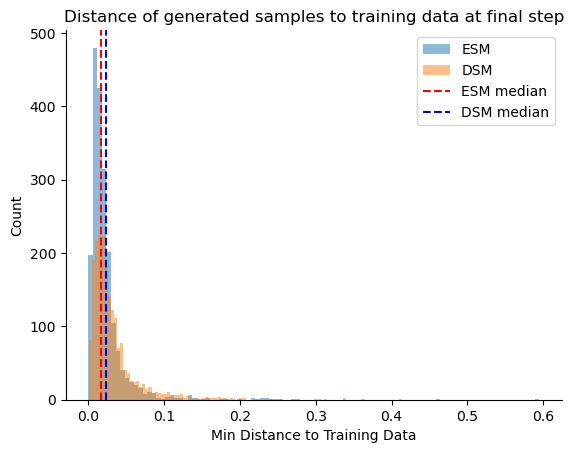

In [42]:
plt.hist(min_dists_esm_all[-1], bins=100, alpha=0.5, label="ESM")
plt.hist(min_dists_dsm_all[-1], bins=100, alpha=0.5, label="DSM")
plt.axvline(x=min_dists_esm_all[-1].median(), color="red", linestyle="--", label="ESM median")
plt.axvline(x=min_dists_dsm_all[-1].median(), color="blue", linestyle="--", label="DSM median")
plt.legend()
plt.xlabel("Min Distance to Training Data")
plt.ylabel("Count")
plt.title("Distance of generated samples to training data at final step")
plt.show()

In [ ]:
import torch
device = get_device()
pnts = pnts.to(device)
sigma = 1.0
model_precd_esm = torch.load(join(savedir, f"model_precd_esm_B4096.pth"))
model_precd_dsm  = torch.load(join(savedir, f"model_precd_dsm_B4096.pth"))
for sigma in [0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]:
    # Create multiple noised versions for better evaluation
    num_reps = 10
    # Create all noised points and sigma vectors at once
    pnts_rep = pnts.repeat(num_reps, 1)
    noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
    sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
    noised_pnts = noised_pnts.to(device)
    sigma_vec = sigma_vec.to(device)
    denoised_esm = model_precd_esm(noised_pnts, sigma_vec)
    denoised_dsm = model_precd_dsm(noised_pnts, sigma_vec)
    denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])
    mmse_esm = torch.mean((denoised_esm - denoised_gmm) ** 2)
    mmse_dsm = torch.mean((denoised_dsm - denoised_gmm) ** 2)
    mmse_gmm = torch.mean((denoised_gmm - pnts_rep) ** 2)
    print(f"sigma: {sigma}\tMMSE of ESM - GMM: {mmse_esm.item():.5f}\tMMSE of DSM - GMM: {mmse_dsm.item():.5f}\tMMSE of GMM - X0: {mmse_gmm.item():.5f}")
    # print(f"MMSE of DSM: {mmse_dsm.item()}")

sigma: 0.002	MMSE of ESM - GMM: 0.00000	MMSE of DSM - GMM: 0.00000	MMSE of GMM - X0: 0.00000
sigma: 0.005	MMSE of ESM - GMM: 0.00003	MMSE of DSM - GMM: 0.00003	MMSE of GMM - X0: 0.00000
sigma: 0.01	MMSE of ESM - GMM: 0.00010	MMSE of DSM - GMM: 0.00010	MMSE of GMM - X0: 0.00000
sigma: 0.05	MMSE of ESM - GMM: 0.00237	MMSE of DSM - GMM: 0.00239	MMSE of GMM - X0: 0.00000
sigma: 0.1	MMSE of ESM - GMM: 0.00916	MMSE of DSM - GMM: 0.00925	MMSE of GMM - X0: 0.00000
sigma: 0.5	MMSE of ESM - GMM: 0.22243	MMSE of DSM - GMM: 0.22460	MMSE of GMM - X0: 0.00000
sigma: 1.0	MMSE of ESM - GMM: 0.87996	MMSE of DSM - GMM: 0.88729	MMSE of GMM - X0: 0.00000
sigma: 2.0	MMSE of ESM - GMM: 3.41779	MMSE of DSM - GMM: 3.43295	MMSE of GMM - X0: 0.00000
sigma: 5.0	MMSE of ESM - GMM: 18.60309	MMSE of DSM - GMM: 18.58813	MMSE of GMM - X0: 0.00000
sigma: 10.0	MMSE of ESM - GMM: 52.73869	MMSE of DSM - GMM: 52.61184	MMSE of GMM - X0: 0.00000
sigma: 20.0	MMSE of ESM - GMM: 97.26589	MMSE of DSM - GMM: 96.57703	MMSE of GMM

/tmp/ipykernel_687894/3079812079.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_precd_esm = torch.load(join(savedir, f"model_precd_esm_B4096.pth"))
/tmp/ipykernel

In [ ]:
import torch
device = get_device()
pnts = pnts.to(device)
sigma = 1.0
model_precd_esm = torch.load(join(savedir, f"model_precd_esm.pth"))
model_precd_dsm  = torch.load(join(savedir, f"model_precd_dsm.pth"))
for sigma in [0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]:
    # Create multiple noised versions for better evaluation
    num_reps = 10
    # Create all noised points and sigma vectors at once
    pnts_rep = pnts.repeat(num_reps, 1)
    noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
    sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
    noised_pnts = noised_pnts.to(device)
    sigma_vec = sigma_vec.to(device)
    denoised_esm = model_precd_esm(noised_pnts, sigma_vec)
    denoised_dsm = model_precd_dsm(noised_pnts, sigma_vec)
    denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])
    mmse_esm = torch.mean((denoised_esm - denoised_gmm) ** 2)
    mmse_dsm = torch.mean((denoised_dsm - denoised_gmm) ** 2)
    mmse_gmm = torch.mean((denoised_gmm - pnts_rep) ** 2)
    print(f"sigma: {sigma}\tMMSE of ESM - GMM: {mmse_esm.item():.5f}\tMMSE of DSM - GMM: {mmse_dsm.item():.5f}\tMMSE of GMM - X0: {mmse_gmm.item():.5f}")
    # print(f"MMSE of DSM: {mmse_dsm.item()}")

sigma: 0.002	MMSE of ESM - GMM: 0.00000	MMSE of DSM - GMM: 0.00000	MMSE of GMM - X0: 0.00000
sigma: 0.005	MMSE of ESM - GMM: 0.00003	MMSE of DSM - GMM: 0.00003	MMSE of GMM - X0: 0.00000
sigma: 0.01	MMSE of ESM - GMM: 0.00010	MMSE of DSM - GMM: 0.00010	MMSE of GMM - X0: 0.00000
sigma: 0.05	MMSE of ESM - GMM: 0.00250	MMSE of DSM - GMM: 0.00250	MMSE of GMM - X0: 0.00000
sigma: 0.1	MMSE of ESM - GMM: 0.00981	MMSE of DSM - GMM: 0.00980	MMSE of GMM - X0: 0.00000
sigma: 0.5	MMSE of ESM - GMM: 0.23247	MMSE of DSM - GMM: 0.23235	MMSE of GMM - X0: 0.00000
sigma: 1.0	MMSE of ESM - GMM: 0.91093	MMSE of DSM - GMM: 0.91056	MMSE of GMM - X0: 0.00000
sigma: 2.0	MMSE of ESM - GMM: 3.51750	MMSE of DSM - GMM: 3.51723	MMSE of GMM - X0: 0.00000
sigma: 5.0	MMSE of ESM - GMM: 18.83013	MMSE of DSM - GMM: 18.81040	MMSE of GMM - X0: 0.00000
sigma: 10.0	MMSE of ESM - GMM: 52.62919	MMSE of DSM - GMM: 52.55639	MMSE of GMM - X0: 0.00000
sigma: 20.0	MMSE of ESM - GMM: 95.42912	MMSE of DSM - GMM: 95.30479	MMSE of GMM

/tmp/ipykernel_687894/2364988184.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_precd_esm = torch.load(join(savedir, f"model_precd_esm.pth"))
/tmp/ipykernel_68789